## Loading and visualization of mineralogical data


References: https://gdr.openei.org/submissions/1005; https://gdr.openei.org/submissions/1405

## 📘 Summary of the Notebook

1. **Loading and Preprocessing**  
   - Defines `load_mineralogy_data` to read mineralogical compositions from a tab‑delimited text file into a pandas DataFrame.  
   - Cleans and converts the last column to string, handling irregular delimiters.

2. **Descriptive Statistics**  
   - Uses `df.describe()` to inspect distributions of mineral percentages and identify data ranges.

3. **2D Visualization**  
   - Implements `plot_well_mineralogy` to draw bar charts of mineral fractions for a specified well, with adjustable bar width.  
   - Extends with `plot_well_mineralogy_with_rocktype` to overlay rock‑type annotations alongside mineralogy bars.

4. **3D Visualization**  
   - Defines `plot_trajectories_pyvista` to render interactive 3D trajectories of mineralogical samples using PyVista.

5. **Spatial Integration**  
   - Recalculates elevation references to True Vertical Depth (TVD).  
   - Maps Northing and Easting coordinates to each well, filtering only wells with measured depth (MD).

6. **Bulk Plotting & Data Extraction**  
   - Provides `plot_all_wells_custom_order_fixed_v1` to generate comparative mineralogy plots for multiple wells in a user‑defined order.  
   - Offers `extract_elevation_data` to slice the dataset at a target elevation (± threshold), save each slice to CSV, and expose results as DataFrames.

## 🎯 Objective

In [1]:
import pandas as pd
def load_mineralogy_data(file_path):
    """
    Carrega os dados de mineralogia a partir de um arquivo de texto, tratando a última coluna como string.

    Args:
    file_path (str): Caminho para o arquivo de dados.

    Returns:
    pd.DataFrame: DataFrame contendo os dados processados.
    """
    try:
        # Carregar os dados com delimitador e limitar colunas para separar corretamente os valores
        df = pd.read_csv(file_path, sep='\t|\s{2,}', engine='python', header=0, dtype=str)

        # Definir os nomes das colunas
        df.columns = ["Well", "MD[ft]", "MD[m]", "Plagioclase[%]", "Kfeldspar[%]", "Quartz[%]", "Others[%]", "RockType(plutonicrocks/IUGSClass)"]

        # Converter colunas numéricas para float
        numeric_cols = ["MD[ft]", "MD[m]", "Plagioclase[%]", "Kfeldspar[%]", "Quartz[%]", "Others[%]"]
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        print("Dados carregados com sucesso!")
        return df

    except FileNotFoundError:
        print(f"Erro: O arquivo {file_path} não foi encontrado.")
    except Exception as e:
        print(f"Erro ao carregar os dados: {e}")

# Caminho do arquivo (atualize conforme necessário)
file_path = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/mineralogy/data_wells_mineralogy.txt"

# Carregar os dados
df_mineralogy = load_mineralogy_data(file_path)

# Exibir as primeiras linhas do dataframe se a carga for bem-sucedida
if df_mineralogy is not None:
    print(df_mineralogy.head())


Dados carregados com sucesso!
    Well  MD[ft]  MD[m]  Plagioclase[%]  Kfeldspar[%]  Quartz[%]  Others[%]  \
0  52-21     230   70.1              41            32         14         13   
1  52-21     500  152.4              34            18         38         10   
2  52-21     700  213.4              44            15         14         28   
3  52-21    1000  304.8              49            13         11         28   
4  52-21    1230  374.9              46            14         11         29   

            RockType(plutonicrocks/IUGSClass)  
0  Sediment w/ lots of glassy rhyolite clasts  
1                                   Sediments  
2                         Quartz monzodiorite  
3                         Quartz monzodiorite  
4                         Quartz monzodiorite  


In [2]:
df_mineralogy.describe()

,MD[ft],MD[m],Plagioclase[%],Kfeldspar[%],Quartz[%],Others[%]
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,5553.803714,1692.803183,39.936340,24.151194,18.220159,17.859416
std,2879.692089,877.731263,14.386799,12.186972,12.836609,14.976715
min,70.000000,21.300000,0.000000,0.000000,1.000000,0.000000
25%,3450.000000,1051.600000,33.000000,13.000000,7.000000,7.000000
50%,5440.000000,1658.100000,43.000000,26.000000,17.000000,13.000000
75%,7540.000000,2298.200000,50.000000,34.000000,27.000000,24.000000
max,12640.000000,3852.700000,69.000000,54.000000,80.000000,99.000000


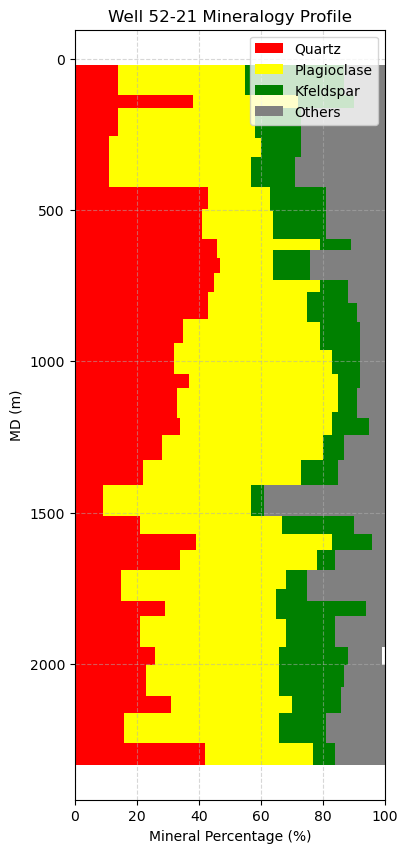

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy(df, well_name, bar_width=5):
    """
    Plota o perfil de mineralogia de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico.
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores para cada mineral
    colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar o gráfico de barras empilhadas
    fig, ax = plt.subplots(figsize=(4, 10))

    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in colors.items():
        ax.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    # Configurações do gráfico
    ax.set_xlabel("Mineral Percentage (%)")
    ax.set_ylabel("MD (m)")
    ax.set_title(f"Well {well_name} Mineralogy Profile")
    ax.set_xlim(0, 100)
    ax.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente

    # Adicionar legenda personalizada
    ax.legend(loc="upper right")

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="52-21", bar_width=100)


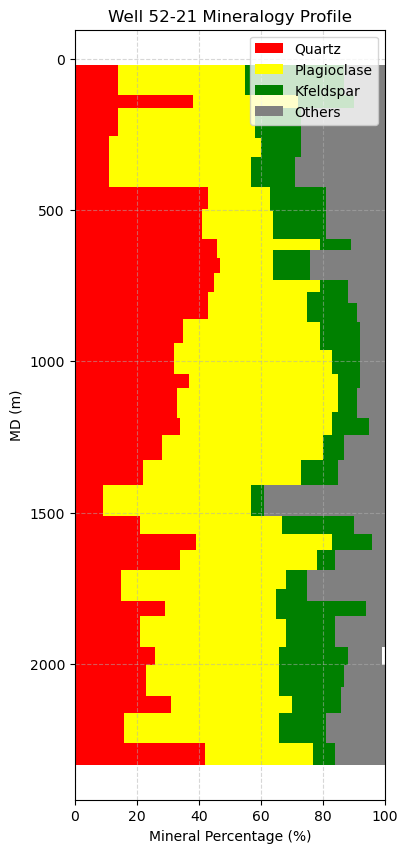

In [4]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="52-21", bar_width=100)

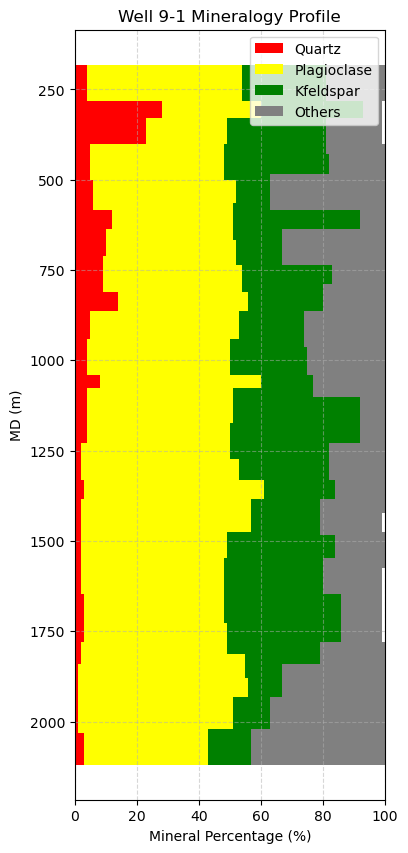

In [5]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="9-1", bar_width=100)

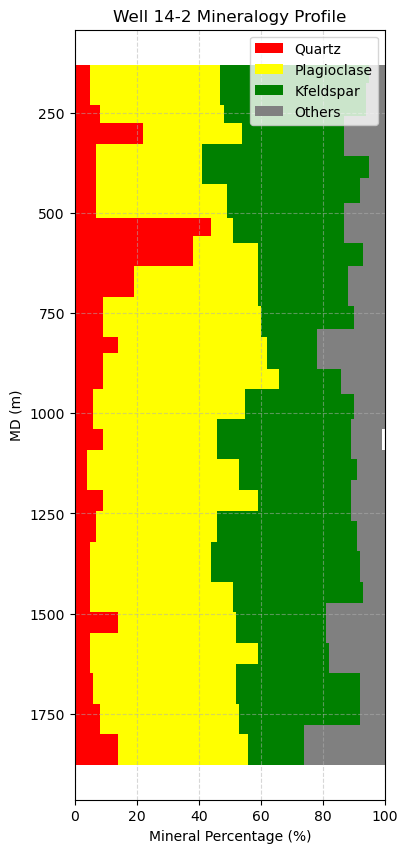

In [6]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="14-2", bar_width=100)

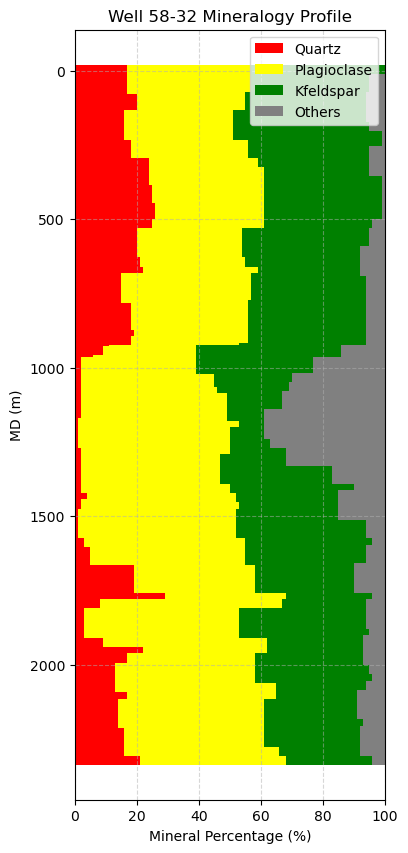

In [7]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="58-32", bar_width=100)

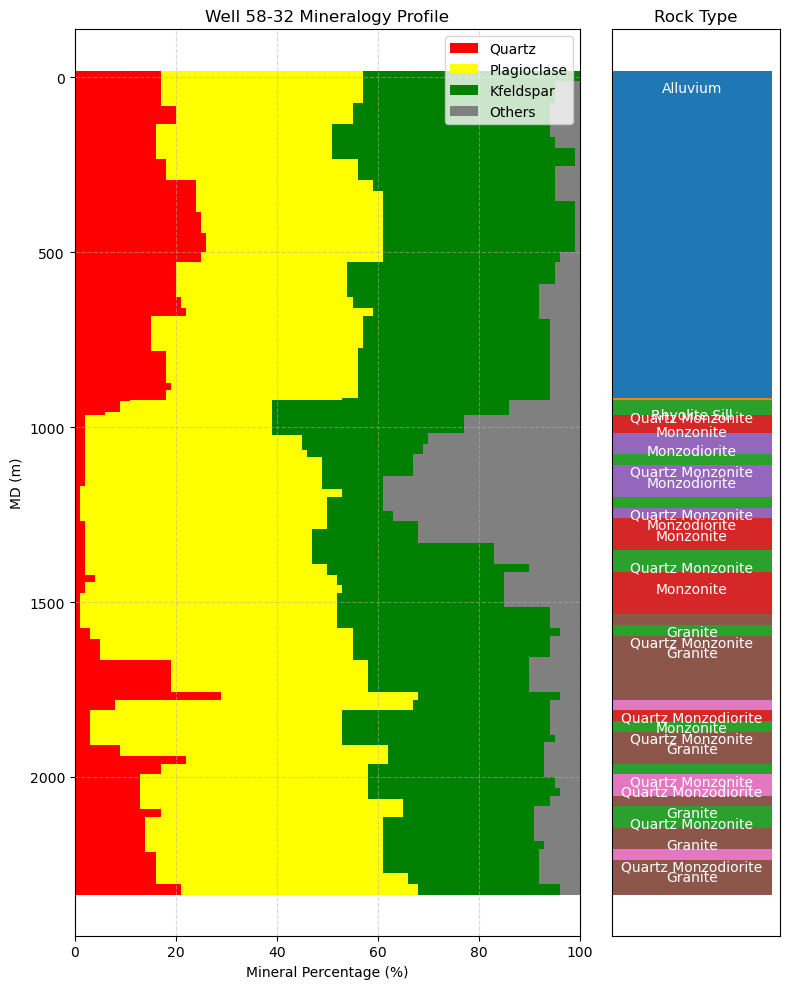

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, rock_colors=None):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        rock_colors = {rock: plt.cm.tab10(i % 10) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)
        if idx == 0 or well_data["RockType(plutonicrocks/IUGSClass)"].iloc[idx] != well_data["RockType(plutonicrocks/IUGSClass)"].iloc[idx - 1]:
            ax2.text(0.5, md, rock, ha='center', va='center', rotation=0, fontsize=10, color='white')

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type")
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100)


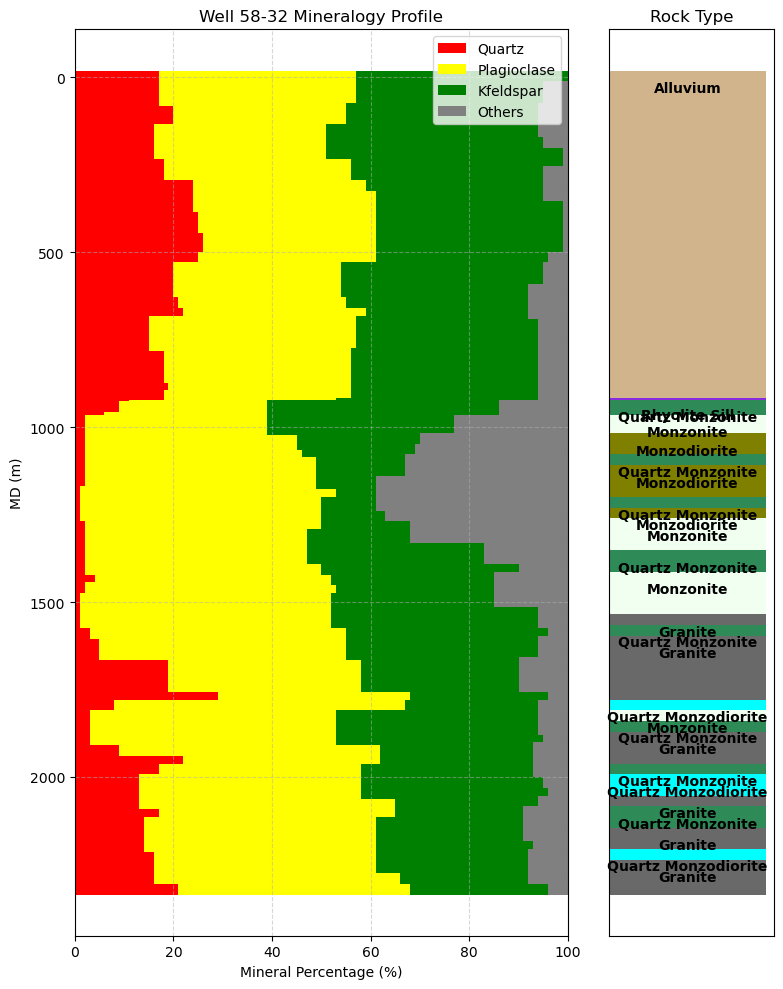

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10"):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)
        if idx == 0 or well_data["RockType(plutonicrocks/IUGSClass)"].iloc[idx] != well_data["RockType(plutonicrocks/IUGSClass)"].iloc[idx - 1]:
            ax2.text(0.5, md, rock, ha='center', va='center', rotation=0, fontsize=10, color='black', weight='bold')

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type")
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Exemplo de chamada da função com cores definidas internamente
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"honeydew",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100, rock_colors=custom_colors)


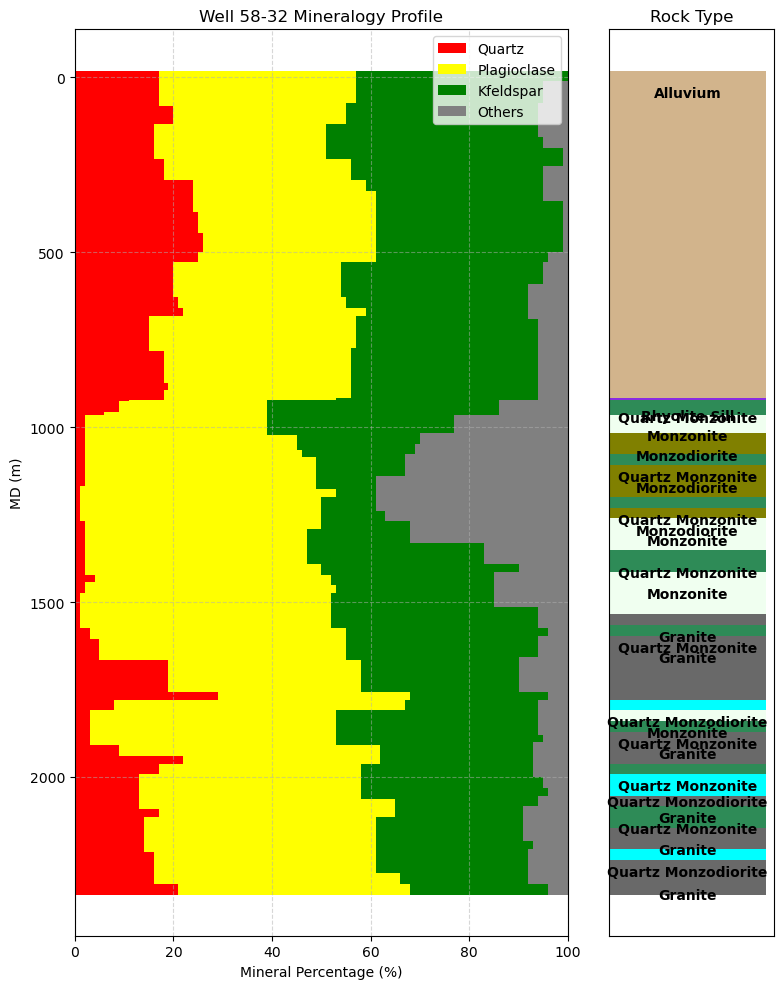

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10"):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)
        
        # Calcular a posição média para centralizar melhor o texto
        if idx < len(well_data["MD[m]"]) - 1:
            md_next = well_data["MD[m]"].iloc[idx + 1]
        else:
            md_next = md + bar_width

        md_center = (md + md_next) / 2  # Encontrar o meio da barra
        
        if idx == 0 or well_data["RockType(plutonicrocks/IUGSClass)"].iloc[idx] != well_data["RockType(plutonicrocks/IUGSClass)"].iloc[idx - 1]:
            ax2.text(0.5, md_center, rock, ha='center', va='center', rotation=0, 
                     fontsize=10, color='black', weight='bold')

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type")
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Exemplo de chamada da função com cores definidas internamente
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"honeydew",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100, rock_colors=custom_colors)


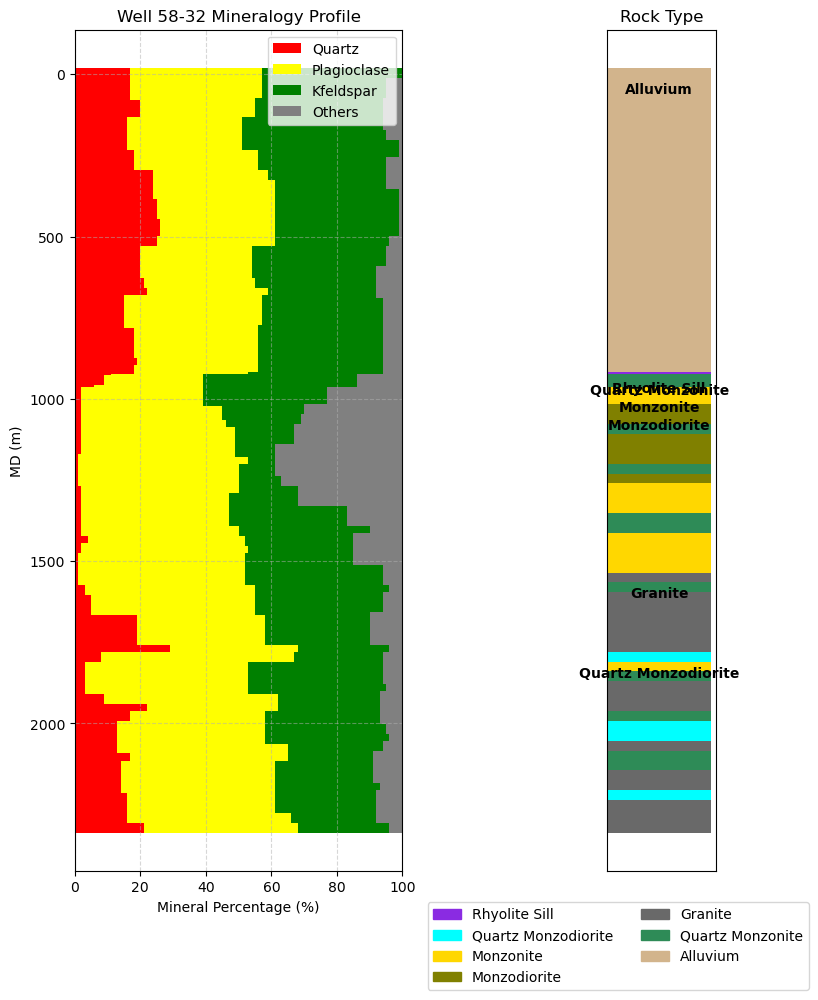

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10"):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    unique_rocks_seen = set()
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

        # Calcular a posição central do intervalo
        if idx < len(well_data["MD[m]"]) - 1:
            md_next = well_data["MD[m]"].iloc[idx + 1]
        else:
            md_next = md + bar_width

        md_center = (md + md_next) / 2  # Posição central exata
        
        if rock not in unique_rocks_seen:
            ax2.text(0.5, md_center, rock, ha='center', va='center', rotation=0, 
                     fontsize=10, color='black', weight='bold')
            unique_rocks_seen.add(rock)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type")
    ax2.invert_yaxis()

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.1, -0.15), 
               ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# Exemplo de chamada da função com cores definidas internamente
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100, rock_colors=custom_colors)


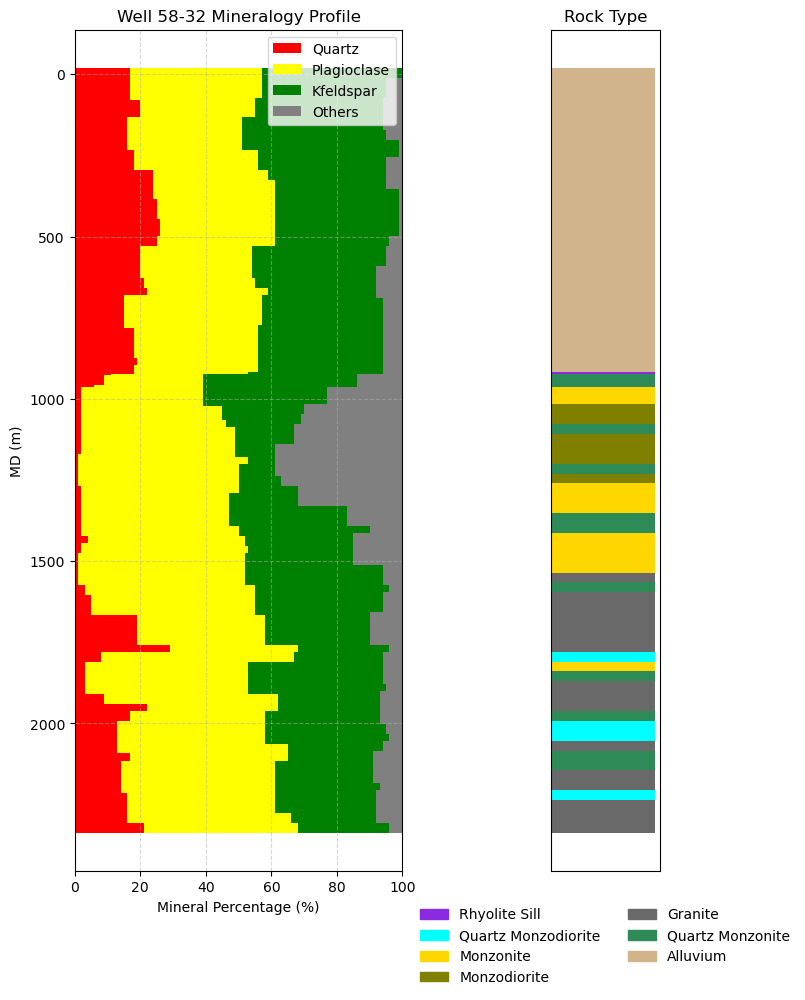

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10"):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type")
    ax2.invert_yaxis()

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# Exemplo de chamada da função com cores definidas internamente
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100, rock_colors=custom_colors)


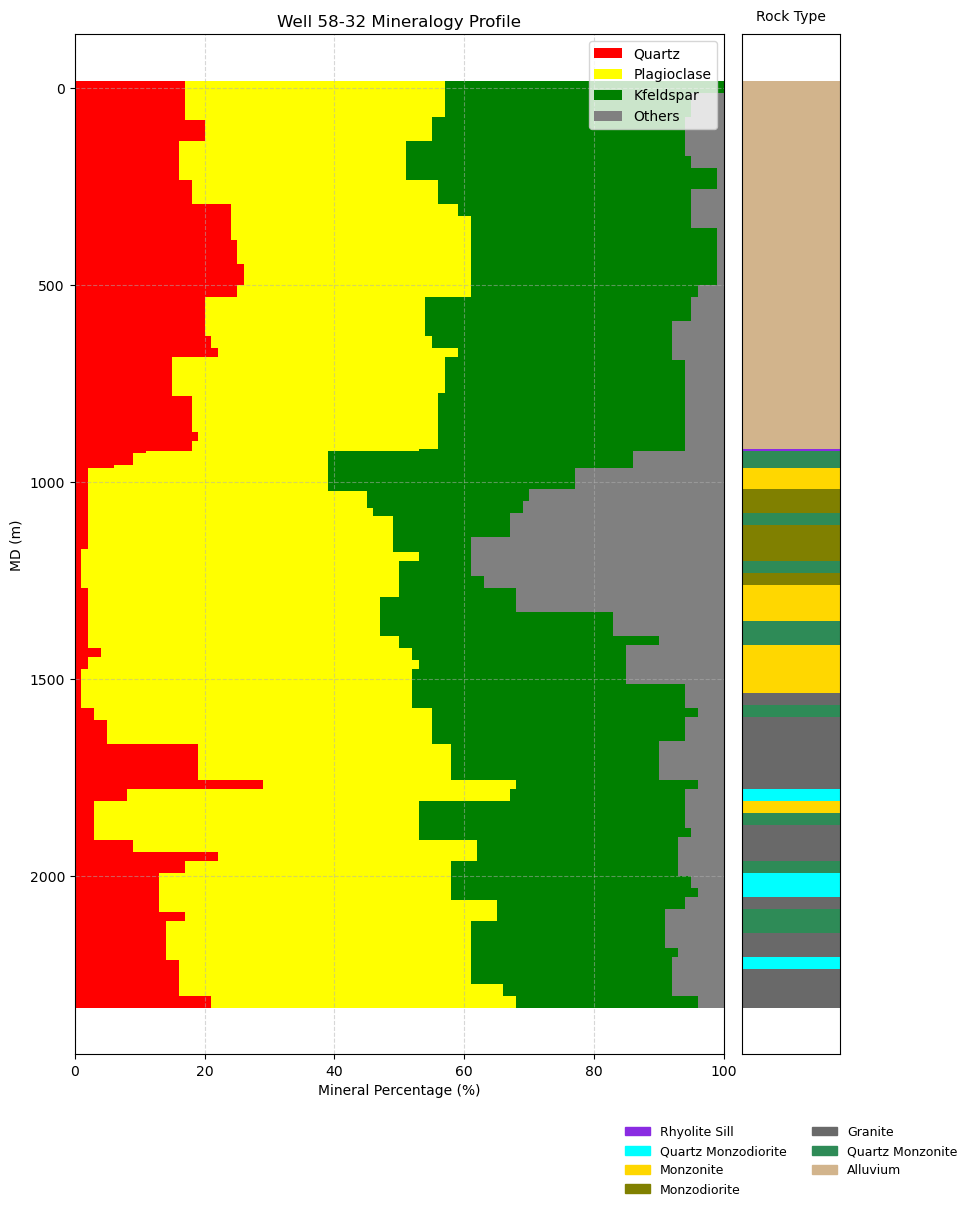

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10"):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(9, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=10, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)  # Ajuste para evitar espaços em branco laterais

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=9)

    # Ajustar espaçamento manualmente para evitar problemas com tight_layout
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com cores definidas internamente
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100, rock_colors=custom_colors)


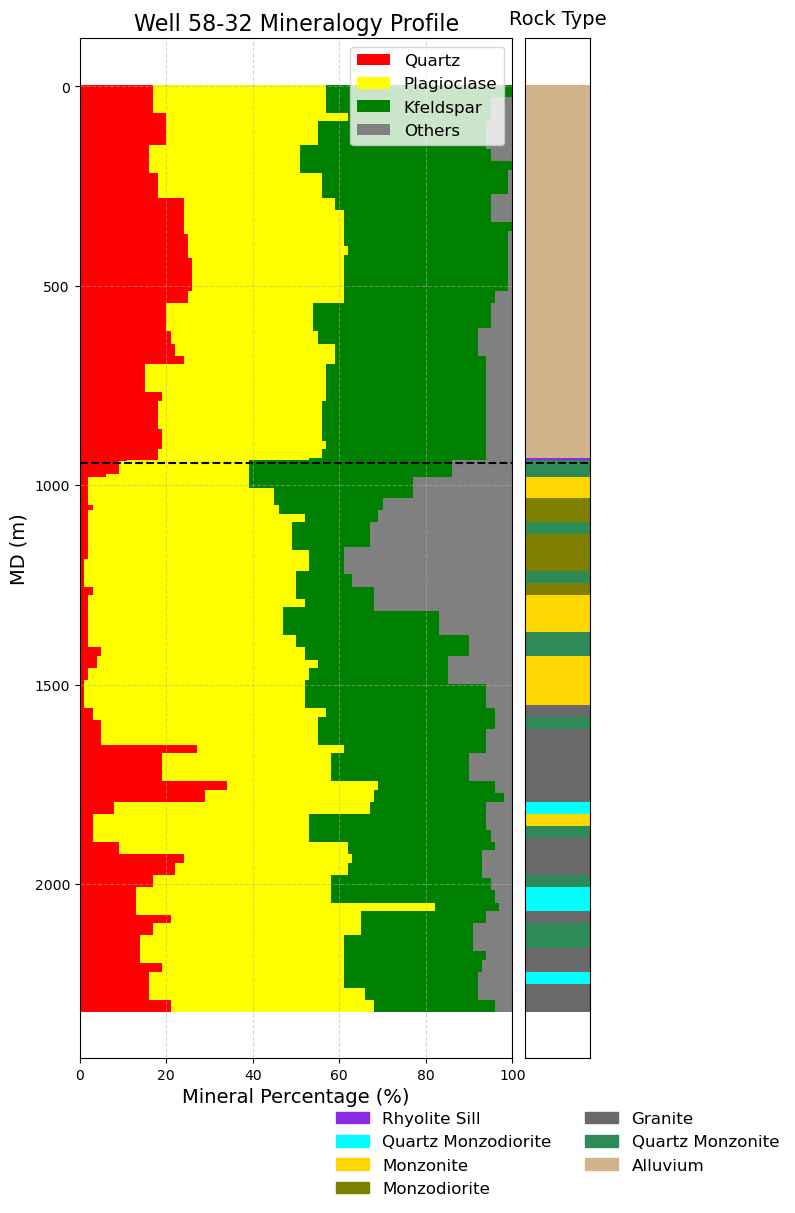

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=12):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico, 
    incluindo uma linha preta pontilhada para indicar a transição entre Alluvium e Rhyolite Sill.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    font_size (int): Tamanho da fonte para todos os elementos do gráfico.
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(6, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)  # Ajuste para evitar espaços em branco laterais

    # Encontrar a profundidade onde ocorre a transição entre Alluvium e Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Alluvium", "MD[m]"].max()

    # Adicionar a linha pontilhada preta nos dois subplots
    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=font_size - 2)

    # Ajustar espaçamento manualmente para evitar problemas com tight_layout
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com cores definidas internamente e ajuste de fonte
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", 
                                   bar_width=70, rock_colors=custom_colors, font_size=14)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


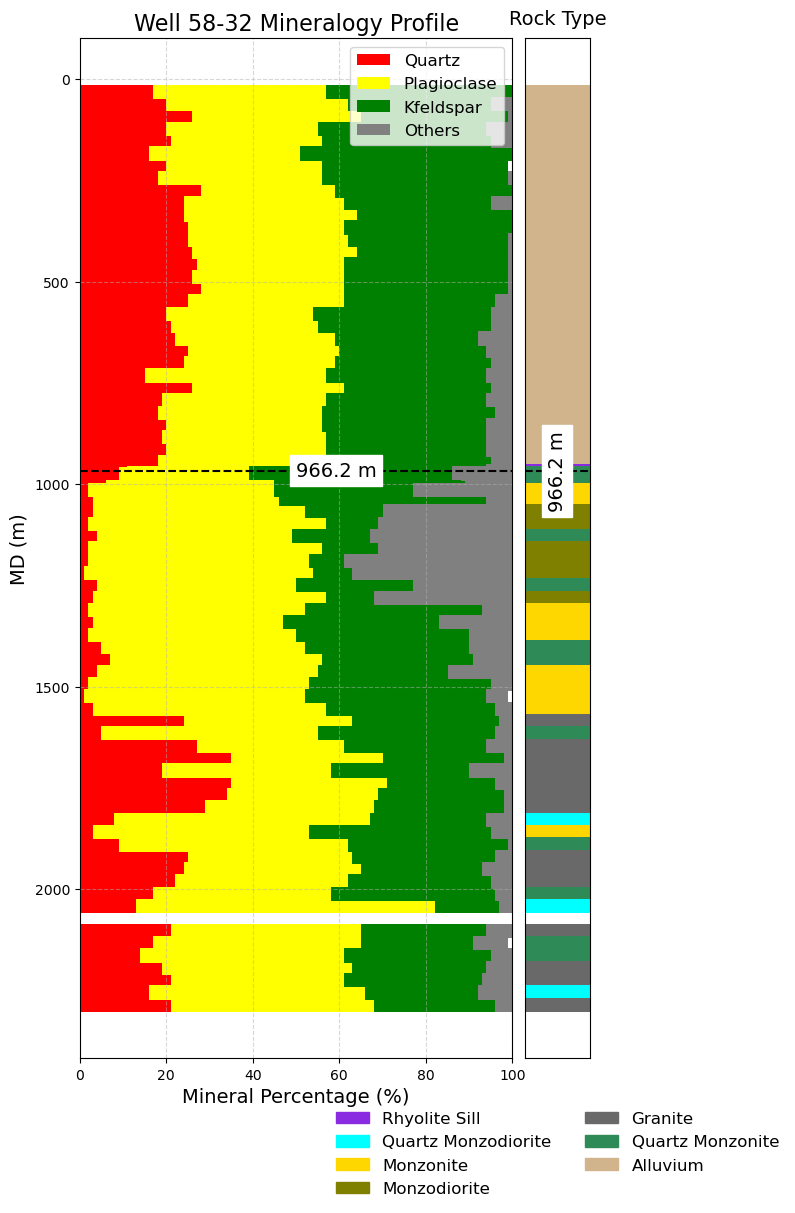

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=12):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico, 
    incluindo uma linha preta pontilhada para indicar a transição entre Alluvium e Rhyolite Sill.
    Mostra o valor da profundidade no eixo Y (MD) da linha de transição.
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(6, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)  # Ajuste para evitar espaços em branco laterais

    # Encontrar a profundidade onde ocorre a transição entre Alluvium e Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()

    # Exibir no console
    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    # Adicionar a linha pontilhada preta nos dois subplots
    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    # Adicionar o texto mostrando o valor no gráfico
    ax1.text(50, transition_depth, f'{transition_depth:.1f} m', 
             va='center', ha='left', fontsize=font_size, color='black', backgroundcolor='white')
    ax2.text(0.5, transition_depth, f'{transition_depth:.1f} m', 
             va='center', ha='center', fontsize=font_size, color='black', backgroundcolor='white', rotation=90)

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=font_size - 2)

    # Ajustar espaçamento manualmente para evitar problemas com tight_layout
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com cores definidas internamente e ajuste de fonte
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", 
                                   bar_width=35, rock_colors=custom_colors, font_size=14)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


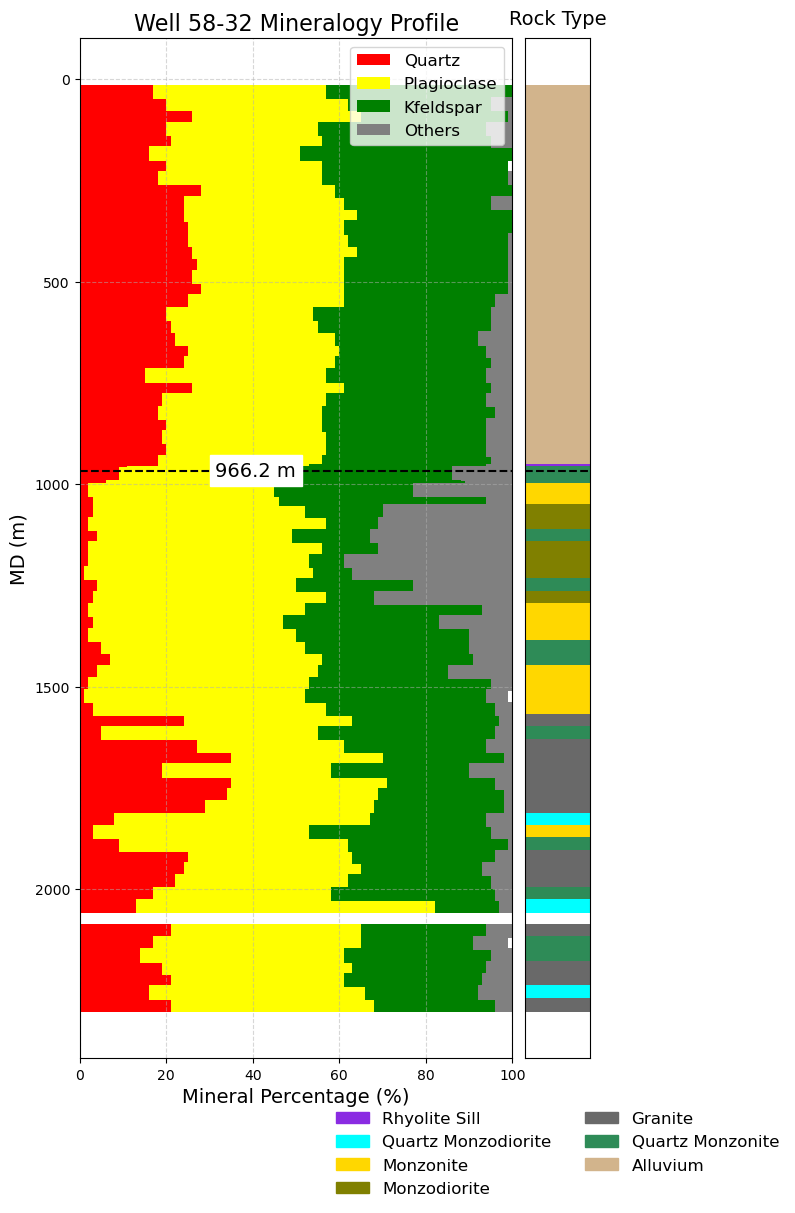

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=12):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico, 
    incluindo uma linha preta pontilhada para indicar a transição entre Alluvium e Rhyolite Sill.
    Mostra o valor da profundidade apenas no gráfico à esquerda (mineralogia), 
    alinhado com o eixo Y.
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(6, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)  # Ajuste para evitar espaços em branco laterais

    # Encontrar a profundidade onde ocorre a transição entre Alluvium e Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()

    # Exibir no console
    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    # Adicionar a linha pontilhada preta nos dois subplots
    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    # Adicionar o texto mostrando o valor da profundidade apenas no gráfico de mineralogia (esquerda)
    ax1.text(50, transition_depth, f'{transition_depth:.1f} m',
             va='center', ha='right', fontsize=font_size, color='black', backgroundcolor='white')

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=font_size - 2)

    # Ajustar espaçamento manualmente para evitar problemas com tight_layout
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com cores definidas internamente e ajuste de fonte
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", 
                                   bar_width=35, rock_colors=custom_colors, font_size=14)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


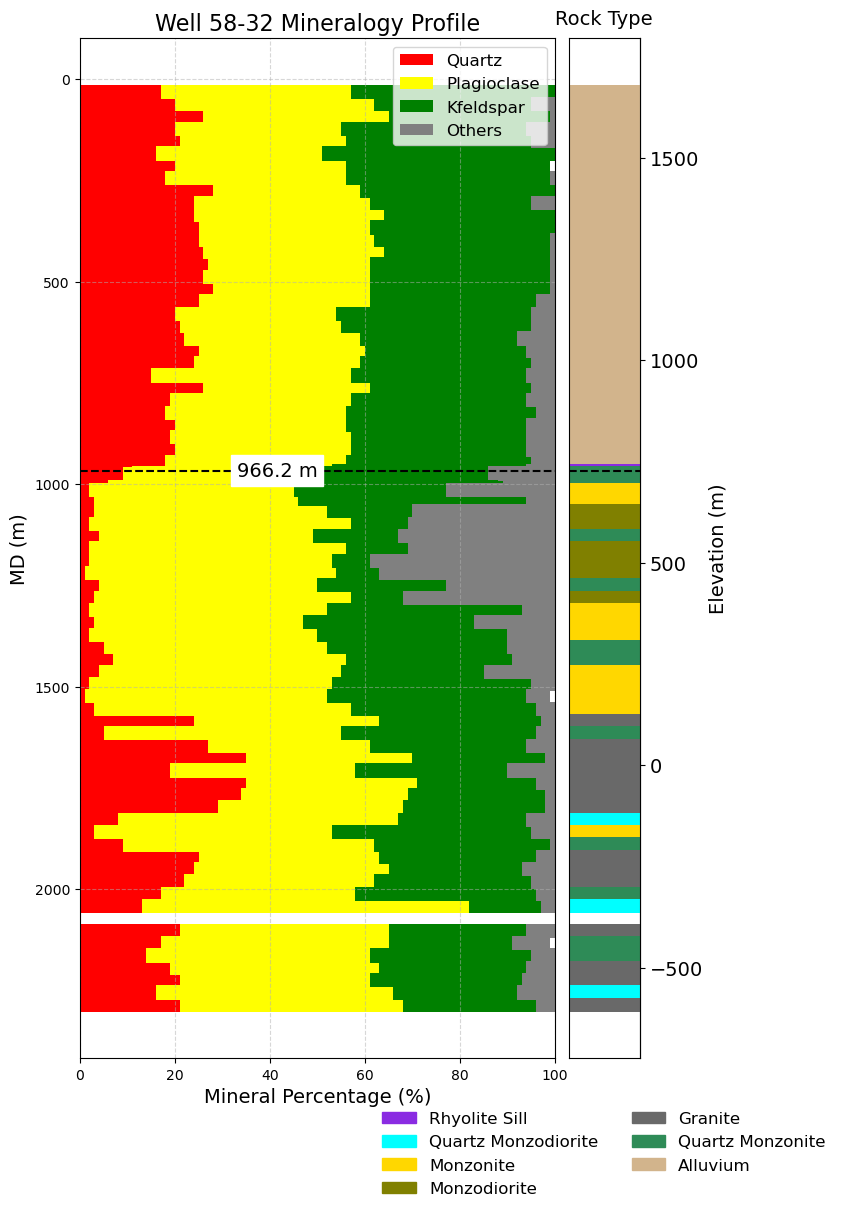

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=14,
                                      kelly_bushing=1693.92):
    """
    Plota o perfil de mineralogia e tipos de rochas de um poço específico,
    incluindo uma linha preta pontilhada para indicar a transição entre Alluvium e Rhyolite Sill.
    Adiciona um eixo secundário à direita do gráfico de Rock Type com valores de Elevation (m).
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(7, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)

    # EIXO SECUNDÁRIO PARA ELEVATION (m) NO LADO DIREITO DO SEGUNDO GRÁFICO (ax2)
    def md_to_elevation(md):
        return kelly_bushing - md

    def elevation_to_md(elev):
        return kelly_bushing - elev

    secax = ax2.secondary_yaxis('right', functions=(md_to_elevation, elevation_to_md))
    secax.set_ylabel('Elevation (m)', fontsize=font_size)
    secax.tick_params(axis='y', labelsize=font_size)

    # Encontrar a profundidade onde ocorre a transição entre Alluvium e Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()

    # Exibir no console
    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    # Adicionar a linha pontilhada preta nos dois subplots
    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    # Adicionar o texto mostrando o valor da profundidade apenas no gráfico de mineralogia (esquerda)
    ax1.text(50, transition_depth, f'{transition_depth:.1f} m',
             va='center', ha='right', fontsize=font_size, color='black', backgroundcolor='white')

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=font_size - 2)

    # Ajustar espaçamento manualmente para evitar problemas com tight_layout
    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com cores definidas internamente e ajuste de fonte
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", 
                                   bar_width=35, rock_colors=custom_colors, font_size=14)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


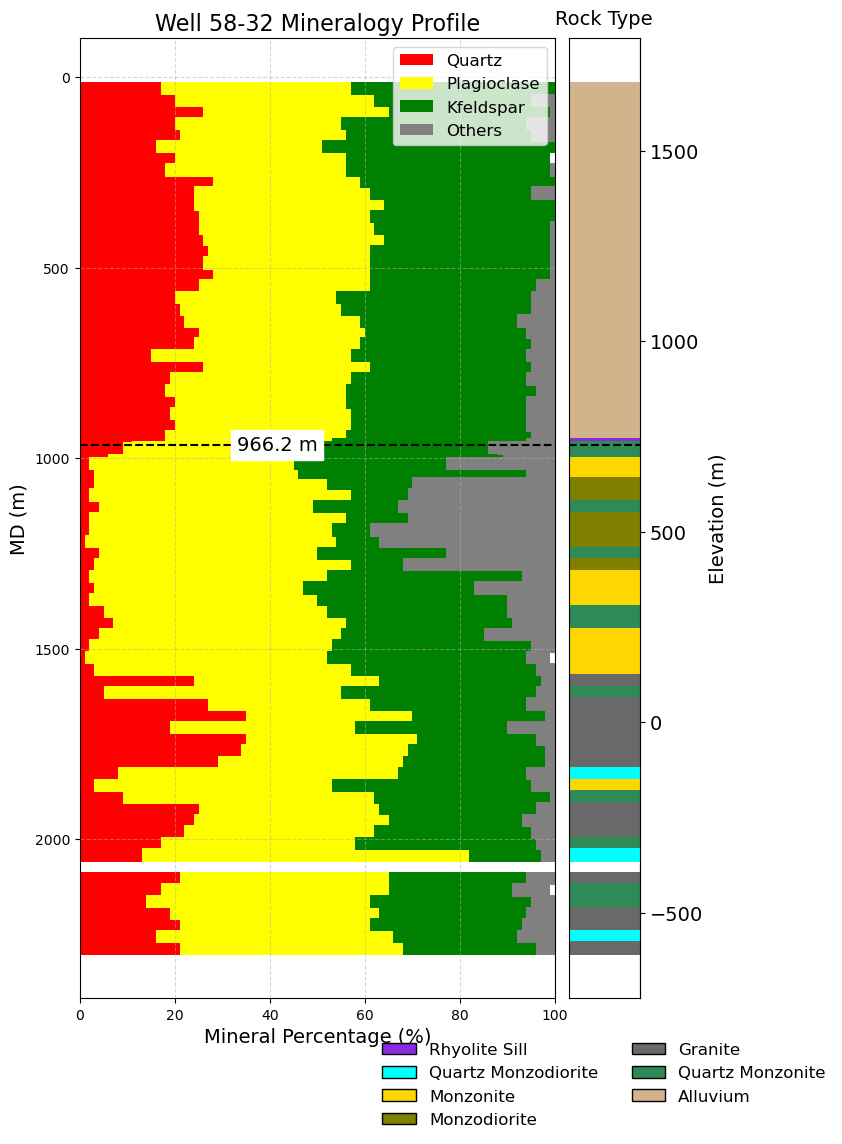

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=12,
                                      kelly_bushing=1693.92):
    """
    Plota o perfil de mineralogia e tipos de rochas de um poço específico,
    incluindo uma linha preta pontilhada para indicar a transição entre Alluvium e Rhyolite Sill.
    Adiciona um eixo secundário à direita do gráfico de Rock Type com valores de Elevation (m).
    Melhora a legenda com contorno preto nos símbolos e texto preto.
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(7, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)

    # EIXO SECUNDÁRIO PARA ELEVATION (m)
    def md_to_elevation(md):
        return kelly_bushing - md

    def elevation_to_md(elev):
        return kelly_bushing - elev

    secax = ax2.secondary_yaxis('right', functions=(md_to_elevation, elevation_to_md))
    secax.set_ylabel('Elevation (m)', fontsize=font_size)
    secax.tick_params(axis='y', labelsize=font_size)

    # Encontrar a profundidade onde ocorre a transição entre Alluvium e Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()

    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    ax1.text(50, transition_depth, f'{transition_depth:.1f} m',
             va='center', ha='right', fontsize=font_size, color='black', backgroundcolor='white')

    # Criar legenda com bordas pretas e texto preto
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')  # Adiciona contorno preto
        for color in rock_colors.values()
    ]

    leg = ax2.legend(
        legend_handles, rock_colors.keys(),
        loc="lower center", bbox_to_anchor=(0.5, -0.15),
        ncol=2, frameon=False, fontsize=font_size - 2
    )

    # Alterar a cor do texto da legenda para preto (aprimora contraste)
    for text in leg.get_texts():
        text.set_color('black')

    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.15, wspace=0.05)

    plt.show()

# Exemplo de chamada da função
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", 
                                   bar_width=35, rock_colors=custom_colors, font_size=14)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


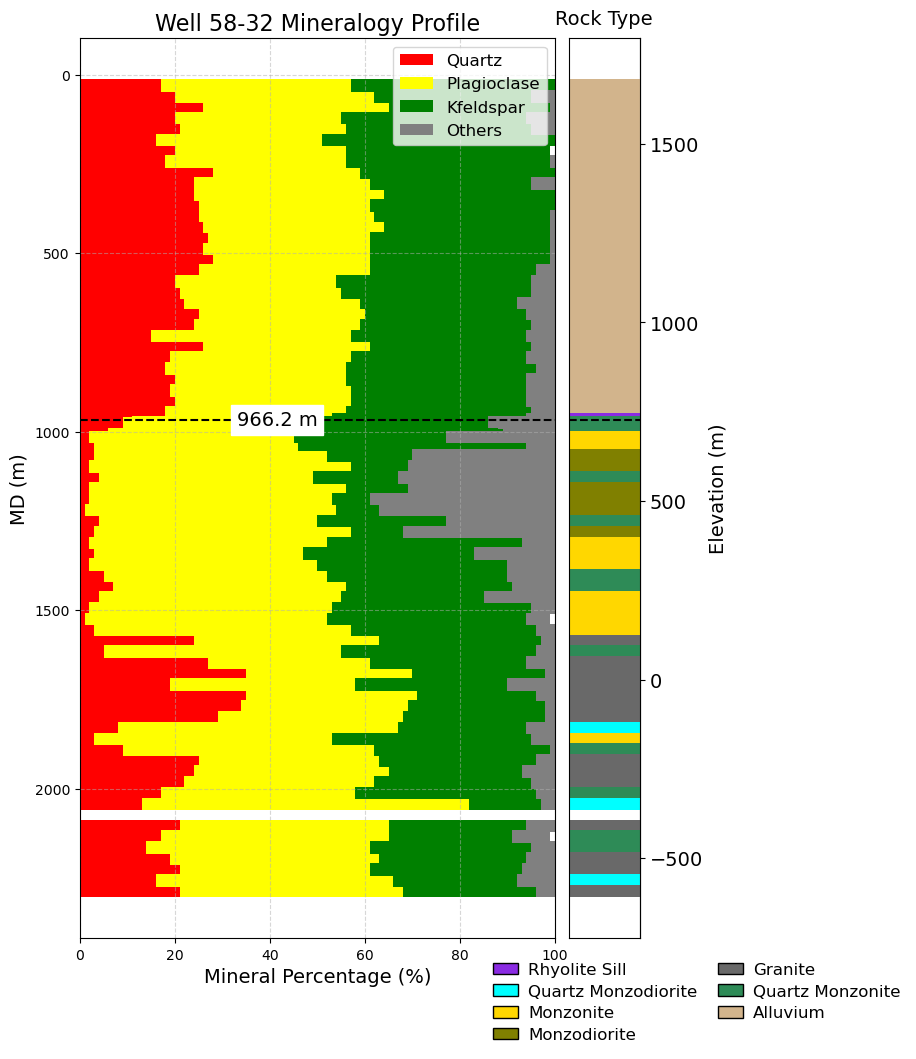

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=12,
                                      kelly_bushing=1693.92):
    """
    Plota o perfil de mineralogia e tipos de rochas de um poço específico,
    incluindo uma linha preta pontilhada para indicar a transição entre Alluvium e Rhyolite Sill.
    Adiciona um eixo secundário à direita do gráfico de Rock Type com valores de Elevation (m).
    Melhora a legenda com contorno preto nos símbolos e texto preto, posicionada abaixo do plot de Rock Type.
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(7, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)

    # EIXO SECUNDÁRIO PARA ELEVATION (m)
    def md_to_elevation(md):
        return kelly_bushing - md

    def elevation_to_md(elev):
        return kelly_bushing - elev

    secax = ax2.secondary_yaxis('right', functions=(md_to_elevation, elevation_to_md))
    secax.set_ylabel('Elevation (m)', fontsize=font_size)
    secax.tick_params(axis='y', labelsize=font_size)

    # Encontrar a profundidade onde ocorre a transição entre Alluvium e Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()

    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    ax1.text(50, transition_depth, f'{transition_depth:.1f} m',
             va='center', ha='right', fontsize=font_size, color='black', backgroundcolor='white')

    # Criar legenda com bordas pretas e texto preto, posicionada abaixo do gráfico de Rock Type (ax2)
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
        for color in rock_colors.values()
    ]

    leg = ax2.legend(
        legend_handles, rock_colors.keys(),
        loc='upper center',
        bbox_to_anchor=(1.8, -0.01),   # Posição vertical abaixo do gráfico de rock type
        ncol=2,                        # Número de colunas
        frameon=False,
        fontsize=font_size - 2,
        handlelength=1.5,              # Tamanho da caixinha na legenda
        handletextpad=0.6,             # Espaço entre caixinha e texto
        columnspacing=1.2,             # Espaço entre colunas
        labelspacing=0.4               # Espaço vertical entre linhas da legenda
    )

    # Alterar a cor do texto da legenda para preto
    for text in leg.get_texts():
        text.set_color('black')

    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.2, wspace=0.05)

    plt.show()

# Exemplo de chamada da função
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", 
                                   bar_width=35, rock_colors=custom_colors, font_size=14)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


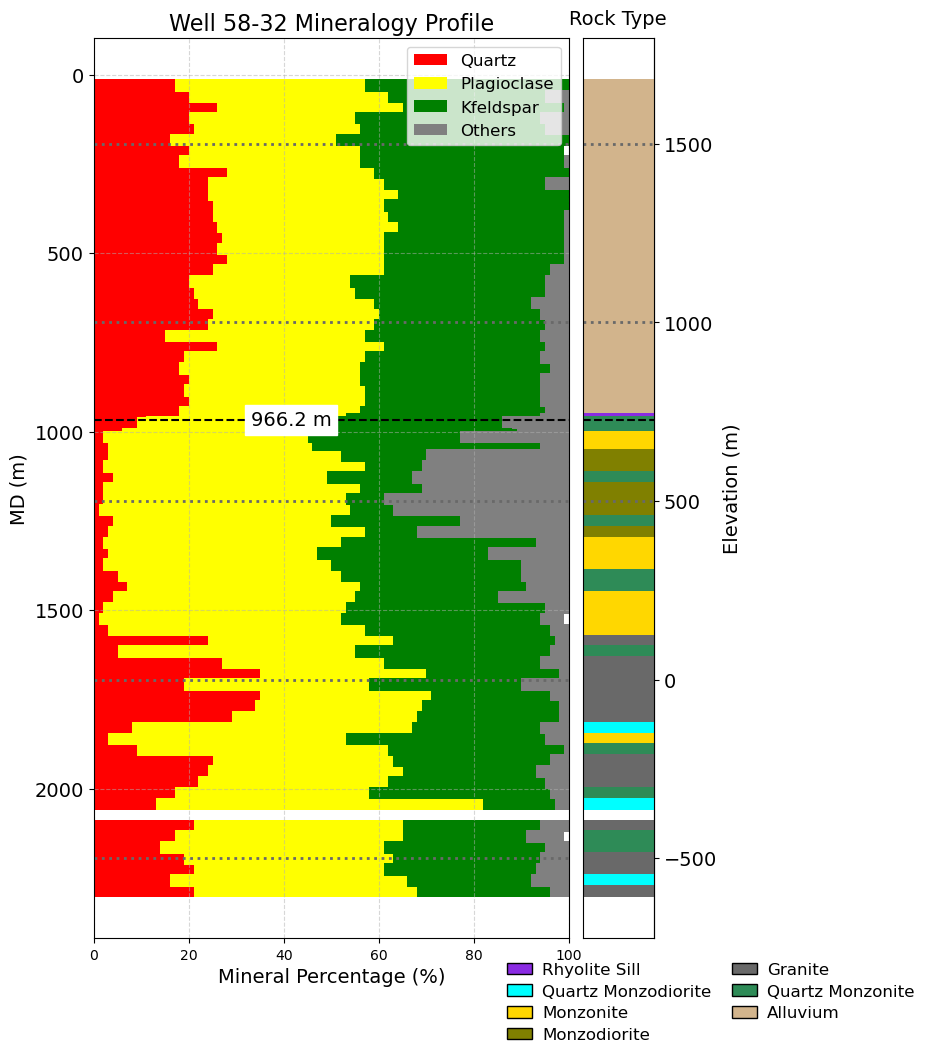

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=12,
                                      kelly_bushing=1693.92,
                                      line_width=1.5):
    """
    Plota o perfil de mineralogia e tipos de rochas de um poço específico,
    incluindo linhas horizontais tracejadas em níveis de elevation específicos.
    Ajuste o tamanho da fonte do eixo MD para 14.
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(7, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    ax1 = axes[0]
    bottom = np.zeros(len(well_data))
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()
    ax1.legend(loc="upper right", fontsize=font_size - 2)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # 🔹 Ajuste do tamanho dos valores do eixo MD
    ax1.tick_params(axis='y', labelsize=14)  # Aqui ajustamos o tamanho da fonte do eixo MD para 14

    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)

    # EIXO SECUNDÁRIO PARA ELEVATION (m)
    def md_to_elevation(md):
        return kelly_bushing - md

    def elevation_to_md(elev):
        return kelly_bushing - elev

    secax = ax2.secondary_yaxis('right', functions=(md_to_elevation, elevation_to_md))
    secax.set_ylabel('Elevation (m)', fontsize=font_size)
    secax.tick_params(axis='y', labelsize=font_size)

    # ----------------------
    # LINHAS TRACEJADAS NAS ELEVATIONS DEFINIDAS
    # ----------------------
    elevations_to_mark = [1500, 1000, 500, 0, -500]
    
    for elev in elevations_to_mark:
        md = elevation_to_md(elev)  # Converte elevation para MD
        # Adiciona linha nos dois gráficos
        ax1.axhline(y=md, color='dimgray', linestyle='dotted', linewidth=line_width)
        ax2.axhline(y=md, color='dimgray', linestyle='dotted', linewidth=line_width)

    # Linha preta da transição Alluvium -> Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()
    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    ax1.text(50, transition_depth, f'{transition_depth:.1f} m',
             va='center', ha='right', fontsize=font_size, color='black', backgroundcolor='white')

    # Criar legenda com bordas pretas e texto preto
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
        for color in rock_colors.values()
    ]

    leg = ax2.legend(
        legend_handles, rock_colors.keys(),
        loc='upper center',
        bbox_to_anchor=(1.8, -0.01),
        ncol=2,
        frameon=False,
        fontsize=font_size - 2,
        handlelength=1.5,
        handletextpad=0.6,
        columnspacing=1.2,
        labelspacing=0.4
    )

    for text in leg.get_texts():
        text.set_color('black')

    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.2, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com controle de espessura da linha
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(
    df_mineralogy,
    well_name="58-32",
    bar_width=35,
    rock_colors=custom_colors,
    font_size=14,
    line_width=2  # AQUI VOCÊ DEFINE A ESPESSURA DAS LINHAS TRACEJADAS
)


Transition from Alluvium to Rhyolite Sill occurs at MD: 966.2 m


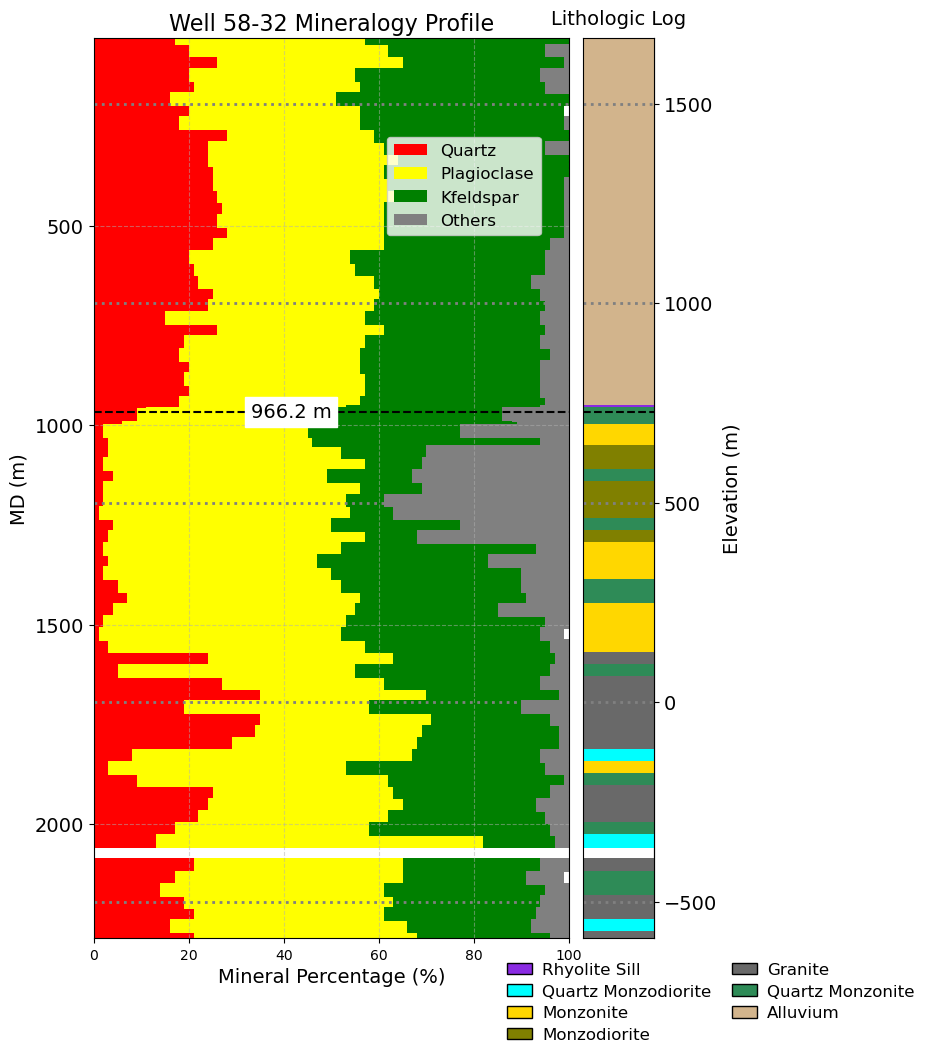

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10",
                                      font_size=14,
                                      kelly_bushing=1693.92,
                                      line_width=1.5,
                                      mineral_legend_loc='upper right',
                                      mineral_legend_bbox=None):
    """
    Plota o perfil de mineralogia e tipos de rochas de um poço específico,
    incluindo linhas horizontais tracejadas em níveis de elevation específicos.
    Permite controle da posição da legenda dos minerais no gráfico de mineralogia.
    """

    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia e tipos de rocha
    fig, axes = plt.subplots(ncols=2, figsize=(7, 12), gridspec_kw={'width_ratios': [4, 0.6], 'wspace': 0.05})

    ax1 = axes[0]
    bottom = np.zeros(len(well_data))
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)", fontsize=font_size)
    ax1.set_ylabel("MD (m)", fontsize=font_size)
    ax1.set_title(f"Well {well_name} Mineralogy Profile", fontsize=font_size + 2)
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()

    # Legenda dos minerais com posição controlada
    ax1.legend(
        loc=mineral_legend_loc,                # Posição padrão ou customizada
        bbox_to_anchor=mineral_legend_bbox,    # Se for None, ignora
        fontsize=font_size - 2,
        frameon=True
    )

    ax1.grid(True, linestyle="--", alpha=0.5)

    # 🔹 Ajuste do tamanho dos valores do eixo MD
    ax1.tick_params(axis='y', labelsize=14)

    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Lithologic Log", fontsize=font_size, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)

    # EIXO SECUNDÁRIO PARA ELEVATION (m)
    def md_to_elevation(md):
        return kelly_bushing - md

    def elevation_to_md(elev):
        return kelly_bushing - elev

    secax = ax2.secondary_yaxis('right', functions=(md_to_elevation, elevation_to_md))
    secax.set_ylabel('Elevation (m)', fontsize=font_size)
    secax.tick_params(axis='y', labelsize=font_size)

    # ----------------------
    # LINHAS TRACEJADAS NAS ELEVATIONS DEFINIDAS
    # ----------------------
    elevations_to_mark = [1500, 1000, 500, 0, -500]
    
    for elev in elevations_to_mark:
        md = elevation_to_md(elev)
        ax1.axhline(y=md, color='gray', linestyle='dotted', linewidth=line_width)
        ax2.axhline(y=md, color='gray', linestyle='dotted', linewidth=line_width)

    # Linha preta da transição Alluvium -> Rhyolite Sill
    transition_depth = well_data.loc[well_data["RockType(plutonicrocks/IUGSClass)"] == "Rhyolite Sill", "MD[m]"].min()
    print(f"Transition from Alluvium to Rhyolite Sill occurs at MD: {transition_depth} m")

    ax1.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)
    ax2.axhline(y=transition_depth, color='black', linestyle='--', linewidth=1.5)

    ax1.text(50, transition_depth, f'{transition_depth:.1f} m',
             va='center', ha='right', fontsize=font_size, color='black', backgroundcolor='white')

    # Legenda do Rock Type
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
        for color in rock_colors.values()
    ]

    leg = ax2.legend(
        legend_handles, rock_colors.keys(),
        loc='upper center',
        bbox_to_anchor=(1.8, -0.01),
        ncol=2,
        frameon=False,
        fontsize=font_size - 2,
        handlelength=1.5,
        handletextpad=0.6,
        columnspacing=1.2,
        labelspacing=0.4
    )

    for text in leg.get_texts():
        text.set_color('black')
    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.2, wspace=0.05)

# Limitar os eixos Y para o range exato de profundidade medida
    ax1.set_ylim(well_data["MD[m]"].max(), well_data["MD[m]"].min())
    ax2.set_ylim(well_data["MD[m]"].max(), well_data["MD[m]"].min())

    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.2, wspace=0.05)
    fig.savefig('mineralogical_58_32_validation_data.pdf', dpi=300, bbox_inches='tight')

    plt.show()

# Exemplo de chamada com controle de posição da legenda dos minerais
custom_colors = {
    "Rhyolite Sill":"blueviolet",
    "Quartz Monzodiorite":"aqua",
    "Monzonite":"gold",
    "Monzodiorite":"olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(
    df_mineralogy,
    well_name="58-32",
    bar_width=35,
    rock_colors=custom_colors,
    font_size=14,
    line_width=2,
    # ✅ Controle da posição da legenda dos minerais
    mineral_legend_loc='upper left',                      # Ex: 'upper left', 'lower right'
    mineral_legend_bbox=(0.6, 0.9)                      # Ex: (horizontal, vertical)
)


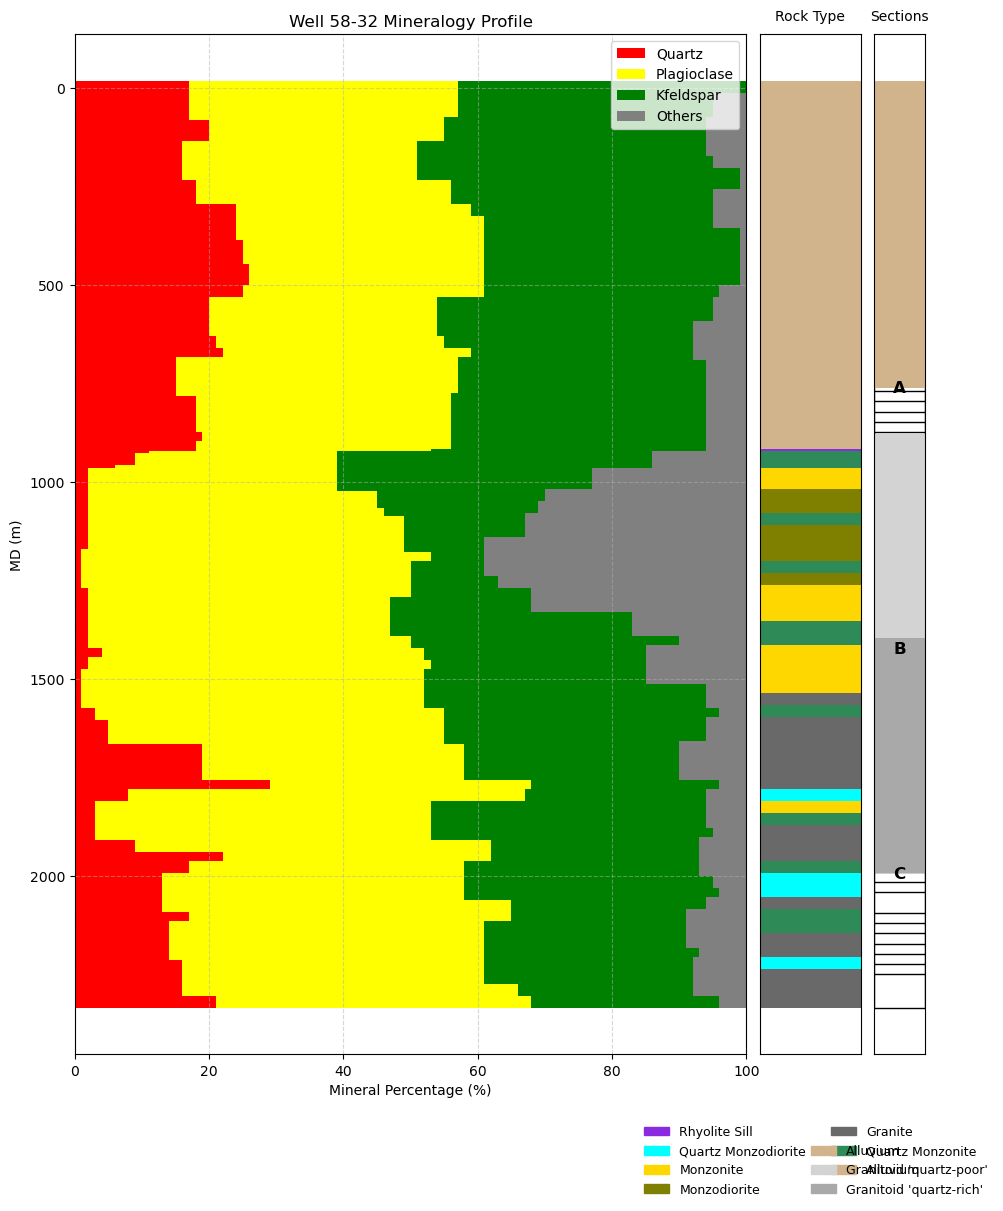

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy_with_rocktype(df, well_name, bar_width=5, 
                                      rock_colors=None, 
                                      default_palette="tab10"):
    """
    Plota o perfil de mineralogia e os tipos de rochas de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos e de tipos de rocha.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico de mineralogia.
    rock_colors (dict): Dicionário opcional de cores para os tipos de rocha.
    default_palette (str): Paleta de cores padrão do Matplotlib (ex: 'tab10', 'Set3', etc.).
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

    # Definir cores padrão para tipos de rocha, caso não sejam fornecidas
    if rock_colors is None:
        unique_rocks = well_data["RockType(plutonicrocks/IUGSClass)"].unique()
        cmap = plt.get_cmap(default_palette)
        rock_colors = {rock: cmap(i % cmap.N) for i, rock in enumerate(unique_rocks)}

    # Definir cores para cada mineral
    mineral_colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar subplots para mineralogia, tipos de rocha e divisão em A, B, C
    fig, axes = plt.subplots(ncols=3, figsize=(10, 12), gridspec_kw={'width_ratios': [4, 0.6, 0.3], 'wspace': 0.05})

    # Gráfico de barras empilhadas para mineralogia
    ax1 = axes[0]
    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in mineral_colors.items():
        ax1.barh(
            well_data["MD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    ax1.set_xlabel("Mineral Percentage (%)")
    ax1.set_ylabel("MD (m)")
    ax1.set_title(f"Well {well_name} Mineralogy Profile")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()
    ax1.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Gráfico de tipos de rocha
    ax2 = axes[1]
    for idx, (md, rock) in enumerate(zip(well_data["MD[m]"], well_data["RockType(plutonicrocks/IUGSClass)"])):
        ax2.barh(md, 1, color=rock_colors[rock], height=bar_width)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Rock Type", fontsize=10, pad=10)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1)

    # Criar legenda na parte inferior
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in rock_colors.values()]
    ax2.legend(legend_handles, rock_colors.keys(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=9)

    # Gráfico para a divisão em A, B e C
    ax3 = axes[2]

    # Definir os limites das seções A, B e C
    alluvium_indices = well_data[well_data["RockType(plutonicrocks/IUGSClass)"] == "Alluvium"].index
    granite_indices = well_data[well_data["RockType(plutonicrocks/IUGSClass)"] == "Granite"].index

    alluvium_top = well_data.loc[alluvium_indices.min(), "MD[m]"]
    alluvium_bottom = well_data.loc[alluvium_indices.max(), "MD[m]"]

    first_granite_md = well_data.loc[granite_indices.min(), "MD[m]"]

    ax3.barh(well_data["MD[m]"], 1, color="white", height=bar_width, edgecolor="black")

    # Adicionar seções A, B e C
    ax3.barh(alluvium_top, 1, color="tan", height=alluvium_bottom - alluvium_top)
    ax3.text(0.5, (alluvium_top + alluvium_bottom) / 2, "A", ha="center", va="center", fontsize=12, weight="bold")

    ax3.barh(alluvium_bottom, 1, color="lightgray", height=first_granite_md - alluvium_bottom)
    ax3.text(0.5, (alluvium_bottom + first_granite_md) / 2, "B", ha="center", va="center", fontsize=12, weight="bold")

    ax3.barh(first_granite_md, 1, color="darkgray", height=well_data["MD[m]"].max() - first_granite_md)
    ax3.text(0.5, (first_granite_md + well_data["MD[m]"].max()) / 2, "C", ha="center", va="center", fontsize=12, weight="bold")

    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Sections", fontsize=10, pad=10)
    ax3.invert_yaxis()
    ax3.set_xlim(0, 1)

    # Legenda para o gráfico de seções
    section_labels = {
        "A": "Alluvium",
        "B": "Granitoid 'quartz-poor'",
        "C": "Granitoid 'quartz-rich'"
    }
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in ["tan", "lightgray", "darkgray"]]
    ax3.legend(legend_handles, section_labels.values(), loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               ncol=1, frameon=False, fontsize=9)

    # Ajustar espaçamento manualmente
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05)

    plt.show()

# Exemplo de chamada da função com cores definidas internamente
custom_colors = {
    "Rhyolite Sill": "blueviolet",
    "Quartz Monzodiorite": "aqua",
    "Monzonite": "gold",
    "Monzodiorite": "olive",
    "Granite": "dimgray",
    "Quartz Monzonite": "seagreen",
    "Alluvium": "tan"
}

plot_well_mineralogy_with_rocktype(df_mineralogy, well_name="58-32", bar_width=100, rock_colors=custom_colors)


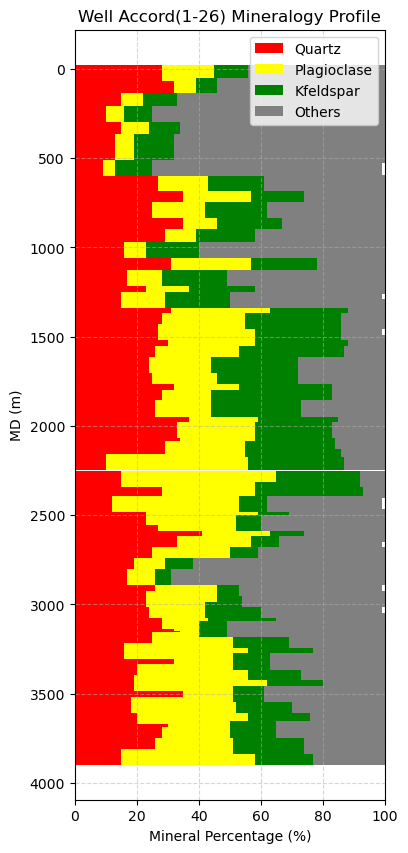

In [8]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="Accord(1-26)", bar_width=90)

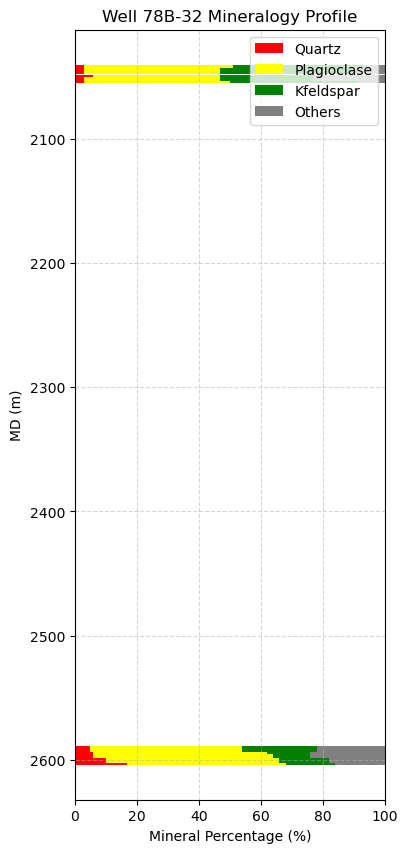

In [9]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="78B-32", bar_width=5)

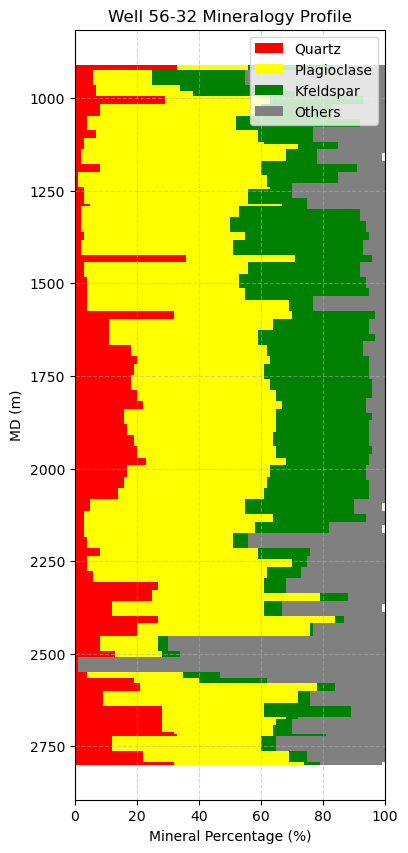

In [10]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="56-32", bar_width=40)

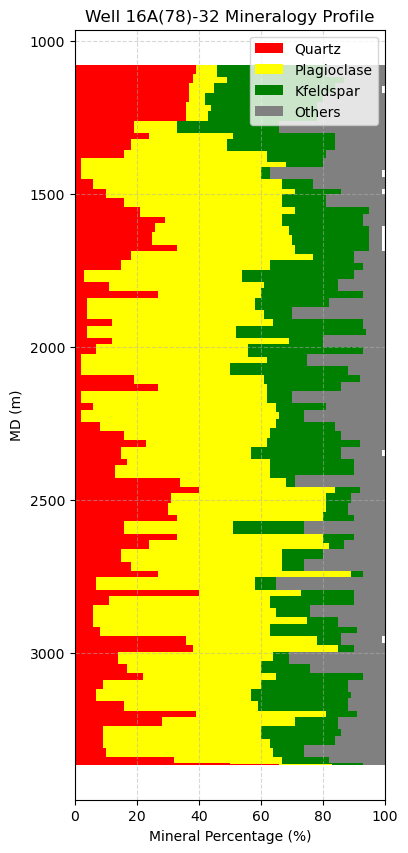

In [11]:
# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy, well_name="16A(78)-32", bar_width=40)

## Def with plot all wells XDR

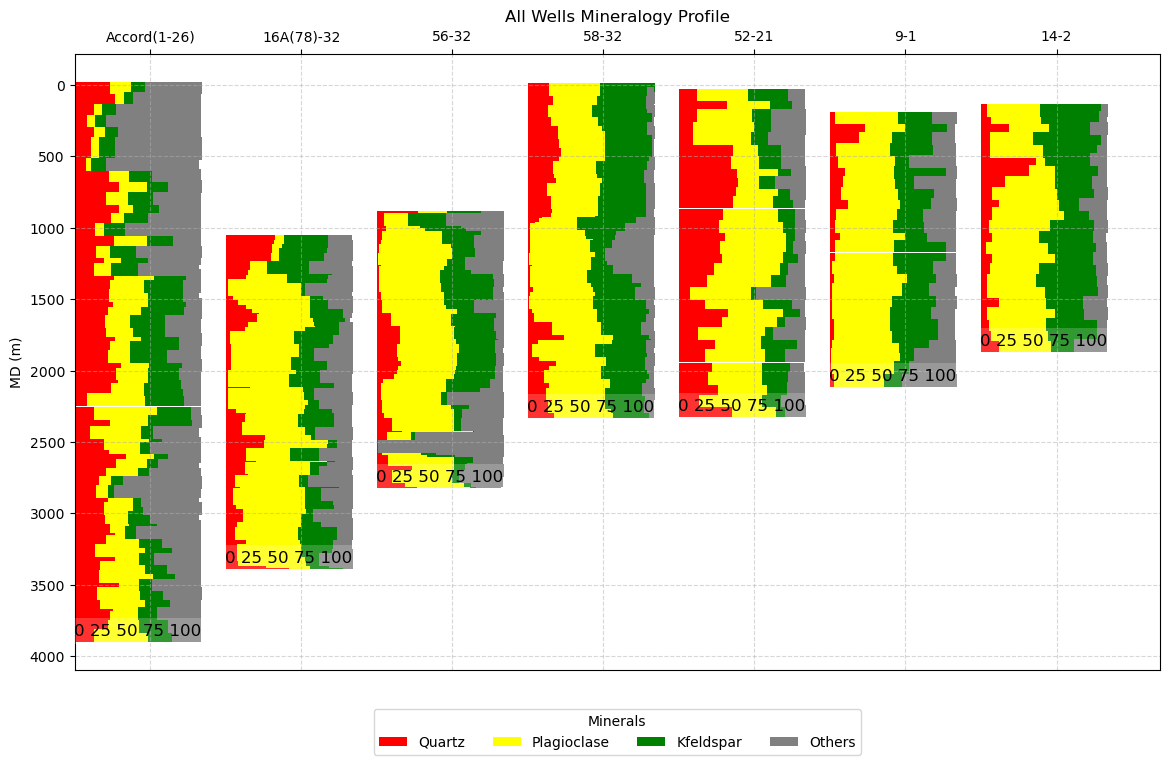

In [4]:
# Função para plotar todos os poços lado a lado com ordem personalizada
def plot_all_wells_custom_order(df, well_order, bar_width=10):
    """
    Plota o perfil de mineralogia para os poços selecionados em uma ordem específica.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos.
    well_order (list): Lista com a ordem dos poços a serem plotados.
    bar_width (int): Largura das barras para o gráfico.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    num_wells = len(well_order)

    # Definir cores para cada mineral
    colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    spacing = 120  # Espaçamento entre os gráficos

    for i, well_name in enumerate(well_order):
        well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

        bottom = np.zeros(len(well_data))  # Inicializar base das barras

        for mineral, color in colors.items():
            ax.barh(
                well_data["MD[m]"],
                well_data[mineral],
                color=color,
                label=mineral.replace("[%]", "") if i == 0 else "",
                left=bottom + i * spacing,  # Ajustar espaçamento entre os poços
                height=bar_width
            )
            bottom += well_data[mineral]

        # Adicionar rótulo de 0 a 100 dentro do plot na posição correta
        ax.text(i * spacing + 50, well_data["MD[m]"].max(), "0 25 50 75 100",
                ha="center", fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.2))

    # Configurações do gráfico
    ax.set_ylabel("MD (m)")
    ax.set_title("All Wells Mineralogy Profile")

    # Adicionar rótulos dos poços no eixo superior X, alinhados corretamente
    ax.set_xticks(np.arange(0, num_wells * spacing, spacing) + spacing / 2)
    ax.set_xticklabels(well_order)
    ax.xaxis.tick_top()  # Colocar labels no topo

    # Adicionar legenda na parte inferior
    ax.legend(title="Minerals", loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Ajustes finais
    ax.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Ordem personalizada dos poços incluindo "Accord(1-26)"
well_order = ["Accord(1-26)","16A(78)-32", "56-32", "58-32", "52-21", "9-1", "14-2"]

# Chamar a função para plotar os poços com a ordem especificada e barras mais largas
plot_all_wells_custom_order(df_mineralogy, well_order, bar_width=90)


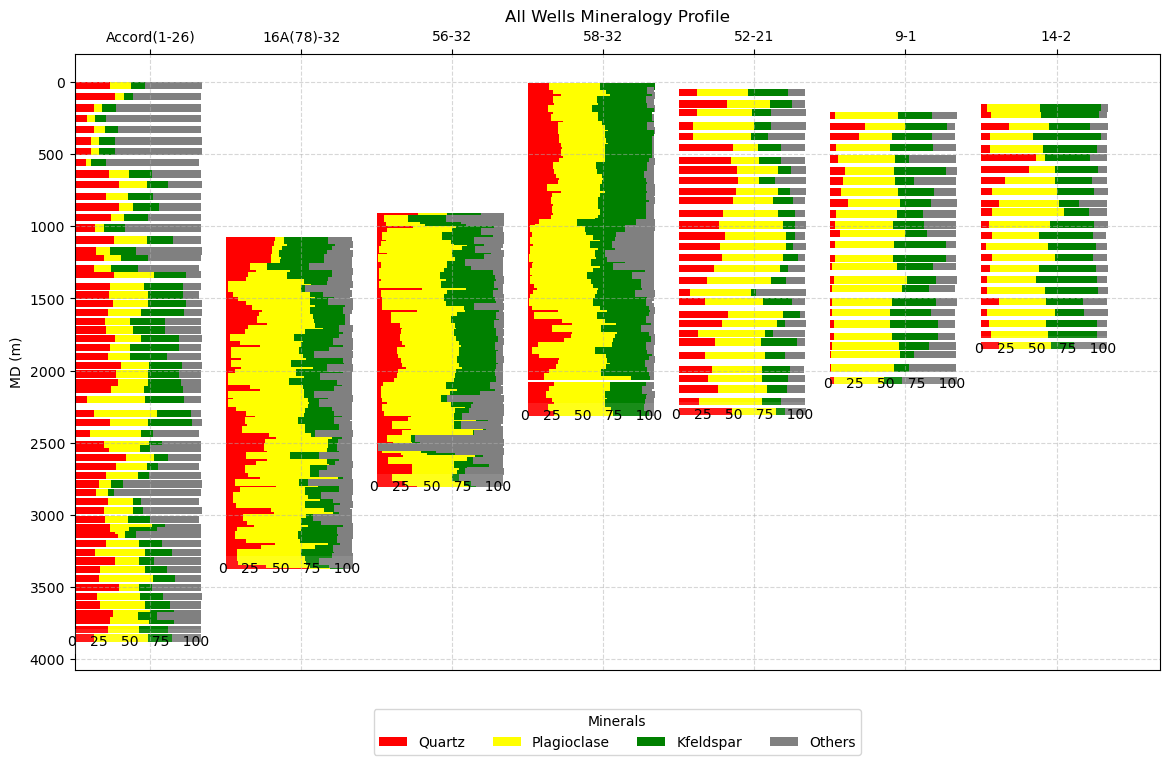

In [5]:
def plot_all_wells_custom_order_fixed(df, well_order, bar_width=10):
    """
    Plota o perfil de mineralogia para os poços selecionados em uma ordem específica,
    com os rótulos de 0 a 100 corretamente posicionados na parte inferior de cada gráfico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos.
    well_order (list): Lista com a ordem dos poços a serem plotados.
    bar_width (int): Largura das barras para o gráfico.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    num_wells = len(well_order)

    # Definir cores para cada mineral
    colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    spacing = 120  # Espaçamento entre os gráficos

    for i, well_name in enumerate(well_order):
        well_data = df[df["Well"] == well_name].sort_values(by="MD[m]")

        bottom = np.zeros(len(well_data))  # Inicializar base das barras

        for mineral, color in colors.items():
            ax.barh(
                well_data["MD[m]"],
                well_data[mineral],
                color=color,
                label=mineral.replace("[%]", "") if i == 0 else "",
                left=bottom + i * spacing,  # Ajustar espaçamento entre os poços
                height=bar_width
            )
            bottom += well_data[mineral].values

        # Adicionar rótulo de 0 a 100 dentro do plot na posição correta na horizontal
        max_x_value = bottom.max() + i * spacing  # Obtendo o valor máximo do eixo X para o poço atual
        ax.text(max_x_value - 50, well_data["MD[m]"].max() + 50, 
                "0   25   50   75   100", ha="center", fontsize=10, rotation=0,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.1))

    # Configurações do gráfico
    ax.set_ylabel("MD (m)")
    ax.set_title("All Wells Mineralogy Profile")

    # Adicionar rótulos dos poços no eixo superior X, alinhados corretamente
    ax.set_xticks(np.arange(0, num_wells * spacing, spacing) + spacing / 2)
    ax.set_xticklabels(well_order)
    ax.xaxis.tick_top()  # Colocar labels no topo

    # Adicionar legenda na parte inferior
    ax.legend(title="Minerals", loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Ajustes finais
    ax.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Ordem personalizada dos poços incluindo "Accord(1-26)"
well_order = ["Accord(1-26)", "16A(78)-32", "56-32", "58-32", "52-21", "9-1", "14-2"]

# Chamar a função para plotar os poços com a ordem especificada e barras mais largas
plot_all_wells_custom_order_fixed(df_mineralogy, well_order, bar_width=50)


## Elevation wells (m)
    Fontes:https://gdr.openei.org/submissions/1440; https://gdr.openei.org/submissions/747

     Insert Real Elevation in data, considering Kellybushing 

In [6]:
import pandas as pd
#fontes:https://gdr.openei.org/submissions/1440; https://gdr.openei.org/submissions/747

# Dados para o dataframe
df_elevation = {
    "Well": ["Accord(1-26)", "16A(78)-32", "56-32", "58-32", "52-21", "9-1", "14-2"],
    "Easting(x)[m]": [330059, 334641.1891, 335504.2787, 335450.9891, 336906.02, 336841.96, 339392.99],
    "Northing(y)[m]": [4265084, 4263443.693, 4263426.189, 4263037.906, 4257739, 4260929.03, 4262171.95],
    "Elevation(z)[m]": [1521, 1650.0249, 1661.652, 1684.7724, 1783.045, 1776.61, 1903.453]
}


# Criar o dataframe
elevation = pd.DataFrame(df_elevation)

# Exibir o dataframe
print(elevation)

           Well  Easting(x)[m]  Northing(y)[m]  Elevation(z)[m]
0  Accord(1-26)    330059.0000     4265084.000        1521.0000
1    16A(78)-32    334641.1891     4263443.693        1650.0249
2         56-32    335504.2787     4263426.189        1661.6520
3         58-32    335450.9891     4263037.906        1684.7724
4         52-21    336906.0200     4257739.000        1783.0450
5           9-1    336841.9600     4260929.030        1776.6100
6          14-2    339392.9900     4262171.950        1903.4530


In [7]:
# Adicionar a coluna 'ElevationReference[m]' ao dataframe df_mineralogy
df_mineralogy["ElevationReference[m]"] = df_mineralogy.apply(
    lambda row: elevation.loc[elevation["Well"] == row["Well"], "Elevation(z)[m]"].values[0] - row["MD[m]"]
    if row["Well"] in elevation["Well"].values else None,
    axis=1
)

# Reorganizar colunas para inserir 'ElevationReference[m]' entre 'TVD[m]' e 'Plagioclase[%]'
column_order = df_mineralogy.columns.tolist()
tvd_index = column_order.index("MD[m]")
column_order.insert(tvd_index + 1, column_order.pop(column_order.index("ElevationReference[m]")))
df_mineralogy = df_mineralogy[column_order]

In [8]:
print(df_mineralogy)

           Well  MD[ft]   MD[m]  ElevationReference[m]  Plagioclase[%]  \
0         52-21     230    70.1              1712.9450              41   
1         52-21     500   152.4              1630.6450              34   
2         52-21     700   213.4              1569.6450              44   
3         52-21    1000   304.8              1478.2450              49   
4         52-21    1230   374.9              1408.1450              46   
..          ...     ...     ...                    ...             ...   
372  16A(78)-32   10900  3322.3             -1672.2751              54   
373  16A(78)-32   10957  3339.7             -1689.6751              46   
374  16A(78)-32   10975  3345.2             -1695.1751              17   
375  16A(78)-32   10980  3346.7             -1696.6751              13   
376  16A(78)-32   10980  3346.7             -1696.6751              17   

     Kfeldspar[%]  Quartz[%]  Others[%]  \
0              32         14         13   
1              18        

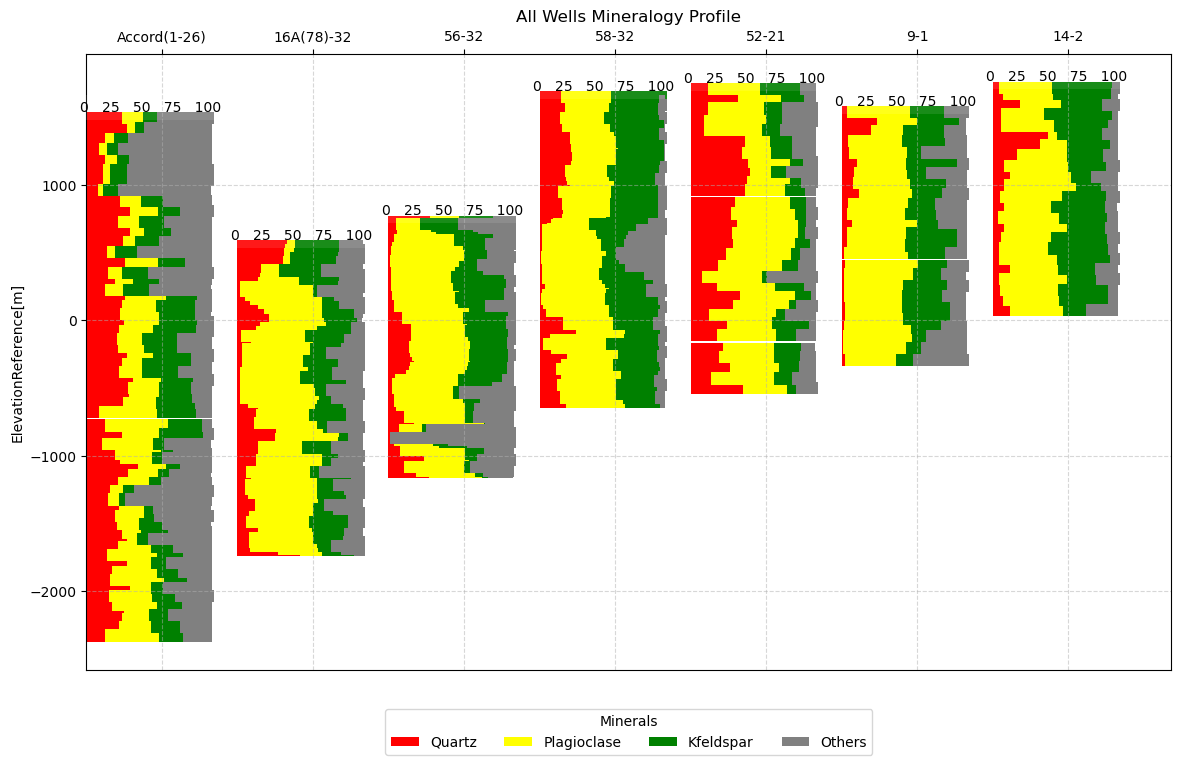

In [9]:
def plot_all_wells_custom_order_fixed_v1(df, well_order, bar_width=10):
    """
    Plota o perfil de mineralogia para os poços selecionados em uma ordem específica,
    com os rótulos de 0 a 100 corretamente posicionados na parte inferior de cada gráfico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos.
    well_order (list): Lista com a ordem dos poços a serem plotados.
    bar_width (int): Largura das barras para o gráfico.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    num_wells = len(well_order)

    # Definir cores para cada mineral
    colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    spacing = 120  # Espaçamento entre os gráficos

    for i, well_name in enumerate(well_order):
        well_data = df[df["Well"] == well_name].sort_values(by="ElevationReference[m]")

        bottom = np.zeros(len(well_data))  # Inicializar base das barras

        for mineral, color in colors.items():
            ax.barh(
                well_data["ElevationReference[m]"],
                well_data[mineral],
                color=color,
                label=mineral.replace("[%]", "") if i == 0 else "",
                left=bottom + i * spacing,  # Ajustar espaçamento entre os poços
                height=bar_width
            )
            bottom += well_data[mineral].values

        # Adicionar rótulo de 0 a 100 dentro do plot na posição correta na horizontal
        max_x_value = bottom.max() + i * spacing  # Obtendo o valor máximo do eixo X para o poço atual
        ax.text(max_x_value - 50, well_data["ElevationReference[m]"].max() + 50, 
                "0   25   50   75   100", ha="center", fontsize=10, rotation=0,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.1))

    # Configurações do gráfico
    ax.set_ylabel("ElevationReference[m]")
    ax.set_title("All Wells Mineralogy Profile")

    # Adicionar rótulos dos poços no eixo superior X, alinhados corretamente
    ax.set_xticks(np.arange(0, num_wells * spacing, spacing) + spacing / 2)
    ax.set_xticklabels(well_order)
    ax.xaxis.tick_top()  # Colocar labels no topo

    # Adicionar legenda na parte inferior
    ax.legend(title="Minerals", loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Ajustes finais
    #ax.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Ordem personalizada dos poços incluindo "Accord(1-26)"
well_order = ["Accord(1-26)", "16A(78)-32", "56-32", "58-32", "52-21", "9-1", "14-2"]

# Chamar a função para plotar os poços com a ordem especificada e barras mais largas
plot_all_wells_custom_order_fixed_v1(df_mineralogy, well_order, bar_width=90)

## Trajectory 16A-32

In [10]:
import pandas as pd

# Atualize o caminho para o arquivo correto
file_path = "/home/marcus/Documentos/qualificacao_mestrado/dados_forge/well_16_A_(78)_32/diretional_well/directional_16A_32_X_Y_TVD_MD_p1.txt"

# Definir os nomes das colunas
columns = ["Easting[m]", "Northing[m]", "TVD[m]", "MD[m]"]

try:
    # Ler o arquivo e carregar no dataframe
    traje_16A_78 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    # Exibir o dataframe diretamente no console
    print(traje_16A_78)
except FileNotFoundError:
    print(f"O arquivo não foi encontrado no caminho especificado: {file_path}")


      Easting[m]  Northing[m]   TVD[m]     MD[m]
0    334641.1891  4263443.693     0.00     0.000
1    334641.1373  4263443.766    30.48    30.480
2    334641.0184  4263443.916    60.96    60.960
3    334640.8691  4263444.065    91.44    91.440
4    334640.7410  4263444.181   121.92   121.920
..           ...          ...      ...       ...
106  335732.5987  4263143.596  2567.08  3230.880
107  335760.4574  4263137.875  2578.03  3261.360
108  335788.5081  4263132.834  2588.84  3291.840
109  335816.5436  4263128.201  2599.86  3322.320
110  335832.0336  4263125.817  2605.81  3339.084

[111 rows x 4 columns]


/tmp/ipykernel_48790/191097937.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  traje_16A_78 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


In [11]:
import pandas as pd
import numpy as np

def merge_and_interpolate(df_mineralogy, traje_16A_78, well_name="16A(78)-32"):
    # Filtrar os dados do poço específico
    well_data = df_mineralogy[df_mineralogy["Well"] == well_name].copy()

    # Interpolar valores das colunas do segundo dataframe para corresponder aos valores de MD[m]
    well_data["Easting[m]"] = np.interp(well_data["MD[m]"], traje_16A_78["MD[m]"], traje_16A_78["Easting[m]"])
    well_data["Northing[m]"] = np.interp(well_data["MD[m]"], traje_16A_78["MD[m]"], traje_16A_78["Northing[m]"])
    well_data["TVD[m]"] = np.interp(well_data["MD[m]"], traje_16A_78["MD[m]"], traje_16A_78["TVD[m]"])

    # Fazer a mesclagem considerando MD[m] e Well
    df_mineralogy = df_mineralogy.merge(
        well_data[["MD[m]", "Well", "Easting[m]", "Northing[m]", "TVD[m]"]],
        on=["MD[m]", "Well"],  # Adicionando "Well" para evitar adicionar a outros poços
        how="left"
    )

    return df_mineralogy

# Chamada da função
df_mineralogy_updated = merge_and_interpolate(df_mineralogy, traje_16A_78)

# Exibir o dataframe atualizado
print(df_mineralogy_updated)


           Well  MD[ft]   MD[m]  ElevationReference[m]  Plagioclase[%]  \
0         52-21     230    70.1              1712.9450              41   
1         52-21     500   152.4              1630.6450              34   
2         52-21     700   213.4              1569.6450              44   
3         52-21    1000   304.8              1478.2450              49   
4         52-21    1230   374.9              1408.1450              46   
..          ...     ...     ...                    ...             ...   
374  16A(78)-32   10975  3345.2             -1695.1751              17   
375  16A(78)-32   10980  3346.7             -1696.6751              13   
376  16A(78)-32   10980  3346.7             -1696.6751              13   
377  16A(78)-32   10980  3346.7             -1696.6751              17   
378  16A(78)-32   10980  3346.7             -1696.6751              17   

     Kfeldspar[%]  Quartz[%]  Others[%]  \
0              32         14         13   
1              18        

In [12]:
import pyvista as pv

def plot_trajectories_pyvista(df_mineralogy_updated, traje_16A_78):
    """
    Plota trajetórias em 3D usando PyVista.

    Args:
    df_mineralogy_updated (pd.DataFrame): Dataframe com dados de mineralogia.
    traje_16A_78 (pd.DataFrame): Dataframe com dados de trajetória.
    """
    # Criar o plotter
    plotter = pv.Plotter()

    # Adicionar os dados de df_mineralogy_updated
    trajectory_mineralogy = pv.lines_from_points(
        df_mineralogy_updated[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_mineralogy, color="blue", line_width=3, label="Mineralogy Trajectory")

    # Adicionar os dados de traje_16A_78
    trajectory_traje = pv.lines_from_points(
        traje_16A_78[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_traje, color="red", line_width=3, label="Trajectory 16A-78")

    # Configurações
    plotter.add_axes(labels_off=False)
    plotter.add_legend()
    plotter.show()

# Exemplo de uso:
# plot_trajectories_pyvista(df_mineralogy_updated, traje_16A_78)


In [13]:
plot_trajectories_pyvista(df_mineralogy_updated, traje_16A_78)

Widget(value='<iframe src="http://localhost:42631/index.html?ui=P_0x77a0d3efc880_0&reconnect=auto" class="pyvi…

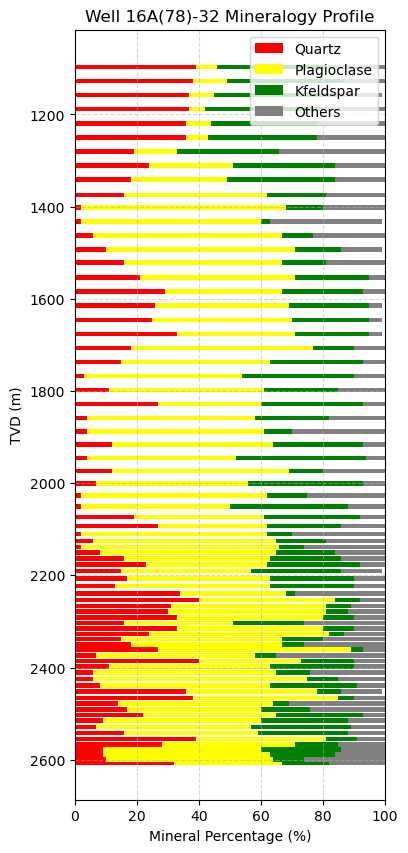

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_well_mineralogy(df, well_name, bar_width=5):
    """
    Plota o perfil de mineralogia de um poço específico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos.
    well_name (str): Nome do poço a ser plotado.
    bar_width (int): Largura das barras para o gráfico.
    """
    # Filtrar os dados para o poço especificado
    well_data = df[df["Well"] == well_name].sort_values(by="TVD[m]")

    # Definir cores para cada mineral
    colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    # Criar o gráfico de barras empilhadas
    fig, ax = plt.subplots(figsize=(4, 10))

    bottom = np.zeros(len(well_data))  # Inicializar base das barras
    for mineral, color in colors.items():
        ax.barh(
            well_data["TVD[m]"],
            well_data[mineral],
            color=color,
            label=mineral.replace("[%]", ""),
            left=bottom,
            height=bar_width
        )
        bottom += well_data[mineral]

    # Configurações do gráfico
    ax.set_xlabel("Mineral Percentage (%)")
    ax.set_ylabel("TVD (m)")
    ax.set_title(f"Well {well_name} Mineralogy Profile")
    ax.set_xlim(0, 100)
    ax.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente

    # Adicionar legenda personalizada
    ax.legend(loc="upper right")

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Chamar a função para plotar o poço 52-21 com barras mais largas
plot_well_mineralogy(df_mineralogy_updated, well_name="16A(78)-32", bar_width=10)


## Recalculating ElevationReference[m] to TVD

In [14]:
# Obter o valor de elevação para o poço "16A(78)-32"
elevation_16A = elevation.loc[elevation["Well"] == "16A(78)-32", "Elevation(z)[m]"].values[0]

# Filtrar apenas os dados do poço "16A(78)-32" no df_mineralogy_updated
mask = df_mineralogy_updated["Well"] == "16A(78)-32"

# Atualizar a coluna ElevationReference[m] usando TVD[m] ao invés de MD[m]
df_mineralogy_updated.loc[mask, "ElevationReference[m]"] = elevation_16A - df_mineralogy_updated.loc[mask, "TVD[m]"]


In [15]:
print(df_mineralogy_updated)

           Well  MD[ft]   MD[m]  ElevationReference[m]  Plagioclase[%]  \
0         52-21     230    70.1              1712.9450              41   
1         52-21     500   152.4              1630.6450              34   
2         52-21     700   213.4              1569.6450              44   
3         52-21    1000   304.8              1478.2450              49   
4         52-21    1230   374.9              1408.1450              46   
..          ...     ...     ...                    ...             ...   
374  16A(78)-32   10975  3345.2              -955.7851              17   
375  16A(78)-32   10980  3346.7              -955.7851              13   
376  16A(78)-32   10980  3346.7              -955.7851              13   
377  16A(78)-32   10980  3346.7              -955.7851              17   
378  16A(78)-32   10980  3346.7              -955.7851              17   

     Kfeldspar[%]  Quartz[%]  Others[%]  \
0              32         14         13   
1              18        

## Adc Northing and Easting to Wells Data 

Adc only wells with MD(m) to depth

In [16]:

# Criar um dicionário de mapeamento para Easting e Northing, excluindo "16A(78)-32"
elevation_filtered = elevation.set_index("Well")[["Easting(x)[m]", "Northing(y)[m]"]].to_dict(orient="index")

# Atualizar apenas os Wells diferentes de "16A(78)-32" sem modificar os já existentes
for idx, row in df_mineralogy_updated.iterrows():
    if row["Well"] in elevation_filtered and row["Well"] != "16A(78)-32":
        df_mineralogy_updated.at[idx, "Easting[m]"] = elevation_filtered[row["Well"]]["Easting(x)[m]"]
        df_mineralogy_updated.at[idx, "Northing[m]"] = elevation_filtered[row["Well"]]["Northing(y)[m]"]

print(df_mineralogy_updated)


           Well  MD[ft]   MD[m]  ElevationReference[m]  Plagioclase[%]  \
0         52-21     230    70.1              1712.9450              41   
1         52-21     500   152.4              1630.6450              34   
2         52-21     700   213.4              1569.6450              44   
3         52-21    1000   304.8              1478.2450              49   
4         52-21    1230   374.9              1408.1450              46   
..          ...     ...     ...                    ...             ...   
374  16A(78)-32   10975  3345.2              -955.7851              17   
375  16A(78)-32   10980  3346.7              -955.7851              13   
376  16A(78)-32   10980  3346.7              -955.7851              13   
377  16A(78)-32   10980  3346.7              -955.7851              17   
378  16A(78)-32   10980  3346.7              -955.7851              17   

     Kfeldspar[%]  Quartz[%]  Others[%]  \
0              32         14         13   
1              18        

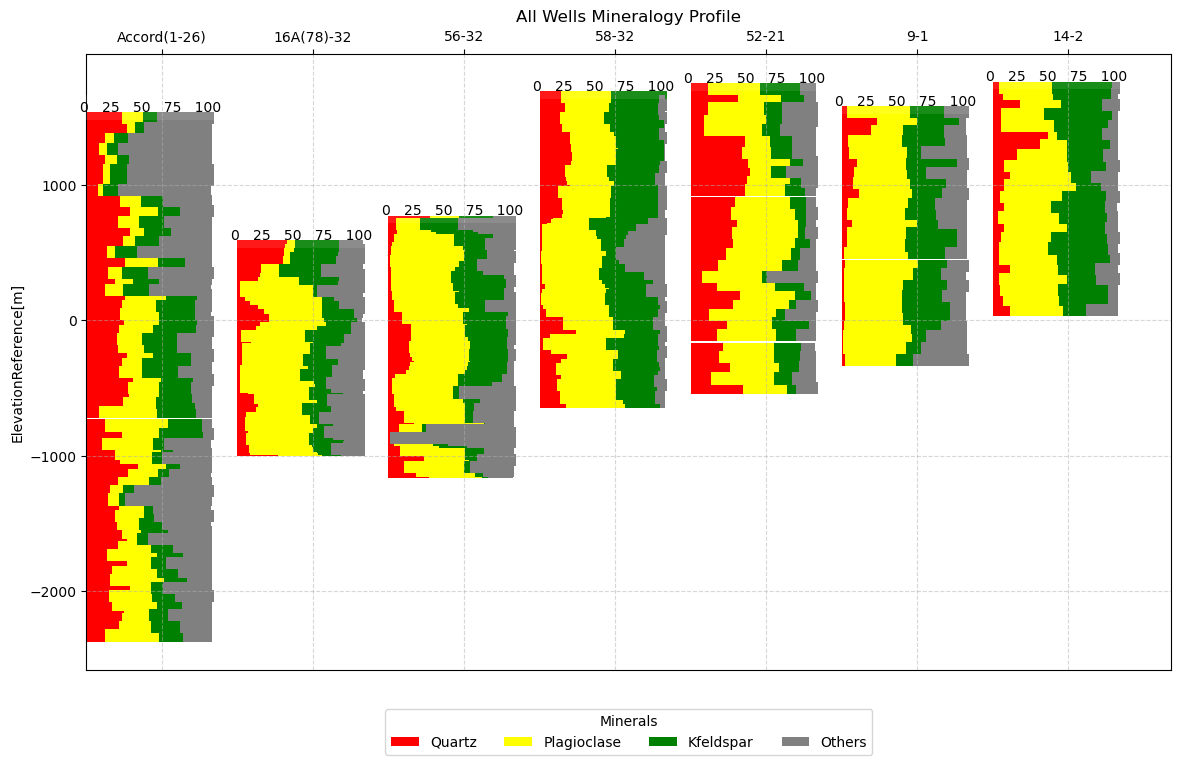

In [17]:
def plot_all_wells_custom_order_fixed_v1(df, well_order, bar_width=10):
    """
    Plota o perfil de mineralogia para os poços selecionados em uma ordem específica,
    com os rótulos de 0 a 100 corretamente posicionados na parte inferior de cada gráfico.

    Args:
    df (pd.DataFrame): DataFrame contendo os dados mineralógicos.
    well_order (list): Lista com a ordem dos poços a serem plotados.
    bar_width (int): Largura das barras para o gráfico.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    num_wells = len(well_order)

    # Definir cores para cada mineral
    colors = {
        "Quartz[%]": "red",
        "Plagioclase[%]": "yellow",
        "Kfeldspar[%]": "green",
        "Others[%]": "gray"
    }

    spacing = 120  # Espaçamento entre os gráficos

    for i, well_name in enumerate(well_order):
        well_data = df[df["Well"] == well_name].sort_values(by="ElevationReference[m]")

        bottom = np.zeros(len(well_data))  # Inicializar base das barras

        for mineral, color in colors.items():
            ax.barh(
                well_data["ElevationReference[m]"],
                well_data[mineral],
                color=color,
                label=mineral.replace("[%]", "") if i == 0 else "",
                left=bottom + i * spacing,  # Ajustar espaçamento entre os poços
                height=bar_width
            )
            bottom += well_data[mineral].values

        # Adicionar rótulo de 0 a 100 dentro do plot na posição correta na horizontal
        max_x_value = bottom.max() + i * spacing  # Obtendo o valor máximo do eixo X para o poço atual
        ax.text(max_x_value - 50, well_data["ElevationReference[m]"].max() + 50, 
                "0   25   50   75   100", ha="center", fontsize=10, rotation=0,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.1))

    # Configurações do gráfico
    ax.set_ylabel("ElevationReference[m]")
    ax.set_title("All Wells Mineralogy Profile")

    # Adicionar rótulos dos poços no eixo superior X, alinhados corretamente
    ax.set_xticks(np.arange(0, num_wells * spacing, spacing) + spacing / 2)
    ax.set_xticklabels(well_order)
    ax.xaxis.tick_top()  # Colocar labels no topo

    # Adicionar legenda na parte inferior
    ax.legend(title="Minerals", loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Ajustes finais
    #ax.invert_yaxis()  # Inverter eixo Y para representar profundidade crescente
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Ordem personalizada dos poços incluindo "Accord(1-26)"
well_order = ["Accord(1-26)", "16A(78)-32", "56-32", "58-32", "52-21", "9-1", "14-2"]

# Chamar a função para plotar os poços com a ordem especificada e barras mais largas
plot_all_wells_custom_order_fixed_v1(df_mineralogy_updated, well_order, bar_width=90)

In [36]:
# import os
# import pandas as pd

# def extract_elevation_data(df, target_elevation, save_csv=False, save_path=None):
#     """
#     Encontra a linha correspondente à cota `target_elevation` para cada poço em `df`.
#     Se não existirem valores acima e abaixo, não salva nenhuma linha para esse poço.

#     Parâmetros:
#     - df: DataFrame contendo os dados de mineralogia.
#     - target_elevation: Valor de `ElevationReference[m]` para buscar em cada `Well`.
#     - save_csv: Se True, salva o resultado em um arquivo CSV.
#     - save_path: Caminho da pasta onde o CSV será salvo (opcional).

#     Retorna:
#     - DataFrame com as linhas filtradas.
#     """
#     wells = df["Well"].unique()  # Lista de todos os poços únicos
#     selected_rows = []  # Lista para armazenar as linhas selecionadas

#     for well in wells:
#         # Filtrar o DataFrame para o poço específico
#         well_data = df[df["Well"] == well].copy()

#         # Ordenar o DataFrame por ElevationReference[m] de forma crescente
#         well_data = well_data.sort_values(by="ElevationReference[m]", ascending=True)
        
#         # Separar os valores menores e maiores que a cota alvo
#         menores = well_data[well_data["ElevationReference[m]"] < target_elevation]
#         maiores = well_data[well_data["ElevationReference[m]"] > target_elevation]

#         # Garantir que temos pelo menos um menor e um maior para tomar a decisão
#         if not menores.empty and not maiores.empty:
#             menor_proximo = menores.iloc[-1]  # Último menor (mais próximo)
#             maior_proximo = maiores.iloc[0]  # Primeiro maior (mais próximo)

#             # Escolher o maior entre os dois
#             selected_row = maior_proximo if maior_proximo["ElevationReference[m]"] - target_elevation < target_elevation - menor_proximo["ElevationReference[m]"] else menor_proximo
            
#             selected_rows.append(selected_row)  # Adicionar a linha selecionada

#     # Criar DataFrame final com as linhas selecionadas
#     selected_df = pd.DataFrame(selected_rows)

#     # Se a opção de salvar em CSV for ativada
#     if save_csv:
#         file_name = f"mineral_{target_elevation}_m.csv"
        
#         # Definir local de salvamento
#         if save_path:
#             os.makedirs(save_path, exist_ok=True)  # Criar a pasta se não existir
#             file_path = os.path.join(save_path, file_name)
#         else:
#             file_path = file_name  # Salvar no diretório atual
        
#         selected_df.to_csv(file_path, index=False)
#         print(f"Arquivo salvo em: {file_path}")

#     return selected_df

# # Exemplo de uso:
# # df_resultado = extract_elevation_data(df_mineralogy_updated, 1500, save_csv=True, save_path="/caminho/para/pasta/")


In [37]:
# df_resultado = extract_elevation_data(df_mineralogy_updated, 1500, save_csv=True, save_path="/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/mineralogy/")


Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/mineralogy/mineral_1500_m.csv


In [33]:
print(df_mineralogy_updated)

           Well  MD[ft]   MD[m]  ElevationReference[m]  Plagioclase[%]  \
0         52-21     230    70.1              1712.9450              41   
1         52-21     500   152.4              1630.6450              34   
2         52-21     700   213.4              1569.6450              44   
3         52-21    1000   304.8              1478.2450              49   
4         52-21    1230   374.9              1408.1450              46   
..          ...     ...     ...                    ...             ...   
374  16A(78)-32   10975  3345.2              -955.7851              17   
375  16A(78)-32   10980  3346.7              -955.7851              13   
376  16A(78)-32   10980  3346.7              -955.7851              13   
377  16A(78)-32   10980  3346.7              -955.7851              17   
378  16A(78)-32   10980  3346.7              -955.7851              17   

     Kfeldspar[%]  Quartz[%]  Others[%]  \
0              32         14         13   
1              18        

In [18]:
import os
import pandas as pd

def extract_elevation_data(df, target_elevation, max_diff=50, save_csv=False, save_path=None):
    """
    Encontra todas as linhas com a menor diferença absoluta para a cota `target_elevation` 
    dentro do limite de `max_diff` para cada poço em `df`. 

    Parâmetros:
    - df: DataFrame contendo os dados de mineralogia.
    - target_elevation: Valor de `ElevationReference[m]` para buscar em cada `Well`.
    - max_diff: Diferença máxima permitida para selecionar uma linha.
    - save_csv: Se True, salva o resultado em um arquivo CSV.
    - save_path: Caminho da pasta onde o CSV será salvo (opcional).

    Retorna:
    - DataFrame com as linhas filtradas.
    """
    wells = df["Well"].unique()  # Lista de todos os poços únicos
    selected_rows = []  # Lista para armazenar as linhas selecionadas

    for well in wells:
        # Filtrar o DataFrame para o poço específico
        well_data = df[df["Well"] == well].copy()

        # Calcular a diferença absoluta em relação à cota alvo
        well_data["Diff"] = (well_data["ElevationReference[m]"] - target_elevation).abs()

        # Filtrar apenas as linhas cuja diferença seja menor ou igual a `max_diff`
        valid_rows = well_data[well_data["Diff"] <= max_diff]

        if not valid_rows.empty:
            # Selecionar todas as linhas que têm a menor diferença absoluta
            min_diff = valid_rows["Diff"].min()
            best_matches = valid_rows[valid_rows["Diff"] == min_diff]
            selected_rows.extend(best_matches.to_dict("records"))

    # Criar DataFrame final com as linhas selecionadas
    selected_df = pd.DataFrame(selected_rows).drop(columns=["Diff"])

    # Se a opção de salvar em CSV for ativada
    if save_csv and not selected_df.empty:
        file_name = f"mineral_{target_elevation}.csv"
        
        # Definir local de salvamento
        if save_path:
            os.makedirs(save_path, exist_ok=True)  # Criar a pasta se não existir
            file_path = os.path.join(save_path, file_name)
        else:
            file_path = file_name  # Salvar no diretório atual
        
        selected_df.to_csv(file_path, index=False)
        print(f"Arquivo salvo em: {file_path}")

    return selected_df






In [26]:
# Executando a função para extrair os dados
df_resultado = extract_elevation_data(df_mineralogy_updated, -2000, max_diff=50, save_csv=True, save_path="/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/mineralogy/")



Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/mineralogy/mineral_-2000.csv
